# Robyn: Marketing Mix Modeling in Python

Welcome to Robyn, a powerful Marketing Mix Modeling (MMM) tool developed by Meta. This notebook demonstrates how to use Robyn to build and analyze marketing mix models.

This notebook demonstrates the basic workflow of using Robyn for Marketing Mix Modeling. For your own analysis:

1. Replace the sample data with your marketing data
2. Adjust the model parameters based on your business context
3. Validate results against your business knowledge 
4. Use the optimization insights to guide marketing budget allocation

For more information, visit the [Robyn documentation](https://github.com/facebookexperimental/Robyn).


## Installation

[Running via pip] Install Robyn using pip.

After installation, you might need to restart your Jupyter kernel to use the newly installed package. You can do this by:
- Going to the Kernel menu
- Selecting "Restart Kernel"



In [8]:
%pip install robynpy==0.1.2

  Using cached robynpy-0.1.2-py3-none-any.whl.metadata (7.0 kB)
  Using cached scikit_learn-1.6.1-cp312-cp312-win_amd64.whl.metadata (15 kB)
  Using cached prophet-1.1.6-py3-none-win_amd64.whl.metadata (3.6 kB)
  Using cached lmfit-1.3.2-py3-none-any.whl.metadata (13 kB)
  Using cached plotnine-0.14.5-py3-none-any.whl.metadata (9.3 kB)
  Using cached nevergrad-1.0.8-py3-none-any.whl.metadata (11 kB)
  Using cached PyQt6-6.8.1-cp39-abi3-win_amd64.whl.metadata (2.1 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached rpy2-3.5.17.tar.gz (220 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Preparing metadata (setup.p


[Running locally] If building locally, make sure we are importing the Robyn modules from the local src directory:

In [ ]:
# import sys
# import os

# notebook_path = os.path.abspath("")
# robyn_path = os.path.abspath(os.path.join(notebook_path, "../../"))
# if robyn_path not in sys.path:
#     sys.path.append(robyn_path)


## Import Required Libraries


In [9]:
import pandas as pd

from robyn.robyn import Robyn
from robyn.data.entities.mmmdata import MMMData
from robyn.data.entities.holidays_data import HolidaysData
from robyn.data.entities.hyperparameters import Hyperparameters, ChannelHyperparameters
from robyn.data.entities.enums import AdstockType, DependentVarType

c:\Users\barre\anaconda3\envs\PAMPAi\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading Simulated Data with `robynpy` if you are running on Google Colab.

[Running via pip] After installing the `robynpy` package using pip, you can load the simulated data by following these steps:


In [4]:
# # Step 1: Import Necessary Libraries
# import importlib
# import robyn
# import os
# import pandas as pd

# # Step 2: Load the `robyn` Package
# pkg = importlib.import_module('robyn')

# # Step 3: Define the Path to Tutorials
# tutorials_path = pkg.__path__[0] + '/tutorials'

# # Step 4: Load and Display Simulated Weekly Data
# dt_simulated_weekly = pd.read_csv(tutorials_path + "/resources/dt_simulated_weekly.csv")
# print("Simulated Data...")
# print(dt_simulated_weekly.head())

# # Step 5: Load and Display Prophet Holidays Data
# dt_prophet_holidays = pd.read_csv(tutorials_path + "/resources/dt_prophet_holidays.csv")
# print("Holidays Data...")
# print(dt_prophet_holidays.head())

## Loading Simulated Data from Local Build

[Running locally] For this demonstration, we'll use simulated data from our local build.

In [10]:
# Load simulated weekly data
dt_simulated_weekly = pd.read_csv("resources/dt_simulated_weekly.csv")

# Load holidays data (used for seasonality modeling)
dt_prophet_holidays = pd.read_csv("resources/dt_prophet_holidays.csv")

## Configure MMM Data

Define the model specification including dependent variables, independent variables, and analysis window. Here's what each parameter means:

### Key Components:
- `dep_var`: Your target metric (e.g., "revenue", "conversions")
- `dep_var_type`: Type of dependent variable ("revenue" for ROI or "conversion" for CPA)
- `date_var`: Column name containing dates
- `window_start/end`: Analysis time period

### Variable Types:
- `paid_media_spends`: Columns containing media spend data (e.g., TV, Facebook, Search)
- `paid_media_vars`: Media exposure metrics (impressions, clicks) in same order as spends
- `context_vars`: External factors (e.g., competitor activities, events, seasonality)
- `organic_vars`: Marketing activities without direct spend (e.g., email, social posts)

Example configuration:

In [12]:
mmm_data_spec = MMMData.MMMDataSpec(
    dep_var="revenue",  # Target variable
    dep_var_type="revenue",  # Type: "revenue" or "conversion"
    date_var="DATE",  # Date column name
    context_vars=["competitor_sales_B", "events"],  # External factors
    paid_media_spends=[
        "tv_S",
        "ooh_S",
        "print_S",
        "facebook_S",
        "search_S",
    ],  # Media spend columns
    paid_media_vars=[
        "tv_S",
        "ooh_S",
        "print_S",
        "facebook_I",
        "search_clicks_P",
    ],  # Media metrics
    organic_vars=["newsletter"],  # Non-paid marketing activities
    window_start="2016-01-01",  # Analysis start date
    window_end="2018-12-31",  # Analysis end date
)

mmm_data = MMMData(data=dt_simulated_weekly, mmmdata_spec=mmm_data_spec)

## Configure Holiday Data

Holiday data helps capture seasonality and special events in your model. The HolidaysData configuration includes:

### Components:
- `dt_holidays`: DataFrame containing holiday/events data
- `prophet_vars`: Time components to model:
  - "trend": Long-term trend
  - "season": Seasonal patterns
  - "holiday": Holiday/event effects
- `prophet_country`: Country code for built-in holidays (e.g., "DE" for Germany)
- `prophet_signs`: Effect direction for each prophet_var:
  - "default": Let the model determine direction
  - "positive": Force positive effect
  - "negative": Force negative effect

Note: You can add custom events (school breaks, promotional periods, etc.) to the holidays data.

In [13]:
holidays_data = HolidaysData(
    dt_holidays=dt_prophet_holidays,
    prophet_vars=["trend", "season", "holiday"],
    prophet_country="DE",
    prophet_signs=["default", "default", "default"],
)

## Configure Hyperparameters

Hyperparameters control how media effects are modeled. Each channel requires three key parameters:

### Media Channel Parameters:
- `alphas`: Controls saturation curve shape [0.5, 3]
  - Lower values (0.5-1): More diminishing returns
  - Higher values (2-3): More S-shaped response
  
- `gammas`: Controls saturation curve inflection point [0.3, 1]
  - Lower values: Earlier diminishing returns
  - Higher values: Later diminishing returns

- `thetas`: Controls adstock decay rate [0, 0.8]
  - Lower values (0-0.2): Fast decay (e.g., Search, Social)
  - Medium values (0.1-0.4): Medium decay (e.g., Print, OOH)
  - Higher values (0.3-0.8): Slow decay (e.g., TV)

### Global Parameters:
- `adstock`: Type of carryover effect modeling
  - "geometric": Fixed decay rate
  - "weibull_cdf": Flexible decay with cumulative distribution
  - "weibull_pdf": Flexible decay with potential peak delay

- `lambda_`: Ridge regression regularization [0, 1]
- `train_size`: Proportion of data for training [0.5, 0.8]

In [14]:
hyperparameters = Hyperparameters(
    hyperparameters={
        "facebook_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0, 0.3],
        ),
        "print_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
        "tv_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.3, 0.8],
        ),
        "search_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0, 0.3],
        ),
        "ooh_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
        "newsletter": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
    },
    adstock=AdstockType.GEOMETRIC,
    lambda_=[0, 1],
    train_size=[0.5, 0.8],
)

## Initialize Robyn

After configuring our data specifications and parameters, we initialize the Robyn model:
1. Create a Robyn instance with an output directory
2. Initialize with our configured inputs:
   - MMM data with variables and time window
   - Holiday data for seasonality
   - Hyperparameters for media transformations

This step prepares our configured data for the modeling process:

In [15]:
robyn = Robyn(working_dir="output")
robyn.initialize(
    mmm_data=mmm_data,
    holidays_data=holidays_data,
    hyperparameters=hyperparameters,
)

INFO: Initialized Robyn in output
2025-02-07 19:07:09,751 - robyn.robyn - INFO - Initialized Robyn in output
INFO: Validating input data
2025-02-07 19:07:09,752 - robyn.robyn - INFO - Validating input data
2025-02-07 19:07:09,753 - robyn.data.validation.mmmdata_validation - INFO - Starting complete MMMData validation
2025-02-07 19:07:09,755 - robyn.data.validation.mmmdata_validation - INFO - Missing and infinite value check passed successfully
2025-02-07 19:07:09,761 - robyn.data.validation.mmmdata_validation - INFO - No-variance check passed successfully
2025-02-07 19:07:09,762 - robyn.data.validation.mmmdata_validation - INFO - Variable names validation passed successfully
2025-02-07 19:07:09,764 - robyn.data.validation.mmmdata_validation - INFO - Date variable validation passed successfully
2025-02-07 19:07:09,767 - robyn.data.validation.mmmdata_validation - INFO - Dependent variable validation passed successfully
2025-02-07 19:07:09,767 - robyn.data.validation.mmmdata_validation - 

In [ ]:
robyn.mmm_data.data.head()

DATE       revenue          tv_S     ooh_S       print_S  \
0 2015-11-23  2.754372e+06  22358.346667       0.0  12728.488889   
1 2015-11-30  2.584277e+06  28613.453333       0.0      0.000000   
2 2015-12-07  2.547387e+06      0.000000  132278.4    453.866667   
3 2015-12-14  2.875220e+06  83450.306667       0.0  17680.000000   
4 2015-12-21  2.215953e+06      0.000000  277336.0      0.000000   

     facebook_I  search_clicks_P     search_S  competitor_sales_B  \
0  2.430128e+07         0.000000     0.000000             8125009   
1  5.527033e+06      9837.238486  4133.333333             7901549   
2  1.665159e+07     12044.119653  3786.666667             8300197   
3  1.054977e+07     12268.070319  4253.333333             8122883   
4  2.934090e+06      9467.248023  3613.333333             7105985   

    facebook_S events    newsletter  
0  7607.132915     na  19401.653846  
1  1141.952450     na  14791.000000  
2  4256.375378     na  14544.000000  
3  2800.490677     na   2800.000000  
4   689.582605     na  15478.000000

## Run Feature Engineering

Run preprocessing transformations on our input data to generate model-ready features:

INFO: Performing feature engineering
2025-02-07 19:27:06,818 - robyn.robyn - INFO - Performing feature engineering
2025-02-07 19:27:06,821 - robyn.modeling.feature_engineering - INFO - Starting feature engineering process
2025-02-07 19:27:06,824 - robyn.modeling.feature_engineering - INFO - Starting Prophet decomposition
2025-02-07 19:27:06,825 - robyn.modeling.feature_engineering - INFO - Starting Prophet decomposition
c:\Users\barre\anaconda3\envs\PAMPAi\Lib\site-packages\prophet\forecaster.py:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
2025-02-07 19:27:07,858 - cmdstanpy - DEBUG - cmd: where.exe tbb.dll
cwd: None
2025-02-07 19:27:07,932 - cmdstanpy - DEBUG - TBB already found in 

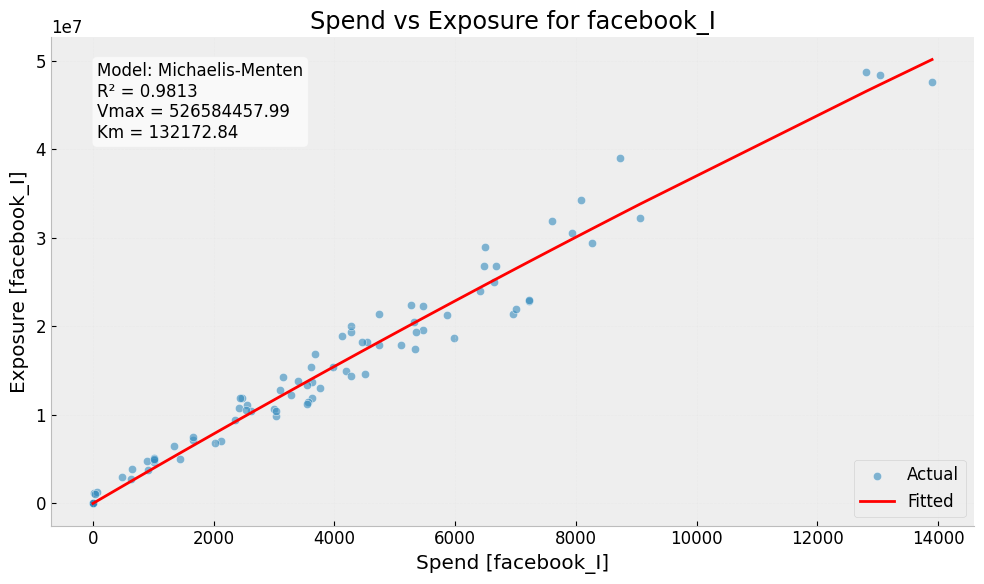

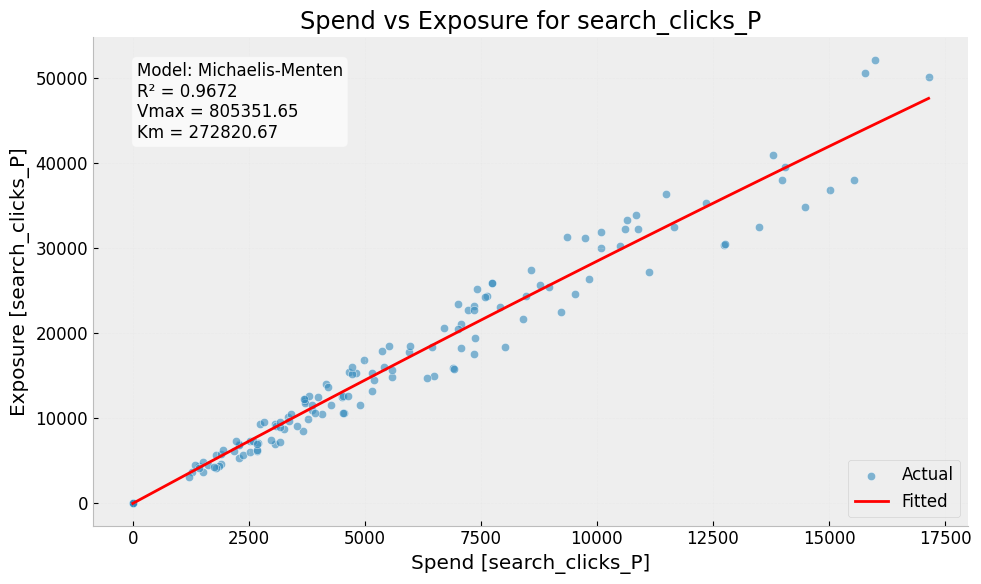

FeaturizedMMMData(dt_mod=            ds       dep_var         trend        season       holiday  \
0   2015-11-23  2.754372e+06  1.715494e+06  1.126401e+06       0.00000   
1   2015-11-30  2.584277e+06  1.716692e+06  9.011862e+05       0.00000   
2   2015-12-07  2.547387e+06  1.717889e+06  7.162871e+05       0.00000   
3   2015-12-14  2.875220e+06  1.719086e+06  6.931405e+05       0.00000   
4   2015-12-21  2.215953e+06  1.720283e+06  7.855933e+05  511762.38912   
..         ...           ...           ...           ...           ...   
203 2019-10-14  2.456240e+06  1.733532e+06  7.397561e+05       0.00000   
204 2019-10-21  2.182825e+06  1.732724e+06  7.952256e+05       0.00000   
205 2019-10-28  2.377707e+06  1.731915e+06  8.694249e+05       0.00000   
206 2019-11-04  2.732825e+06  1.731107e+06  1.015051e+06       0.00000   
207 2019-11-11  2.767788e+06  1.730298e+06  1.174810e+06       0.00000   

     competitor_sales_B  events          tv_S          ooh_S       print_S  \
0       

In [20]:
%matplotlib inline
# Run feature engineering
robyn.feature_engineering()

## Model Training

Configure and execute model training using multiple trials and iterations to find optimal solutions. Key settings include:
- Number of trials and iterations for optimization
- Time-series validation for robustness
- Parallel processing configuration
- Model type and regularization settings

INFO: Training models
2025-02-07 19:27:22,352 - robyn.robyn - INFO - Training models
2025-02-07 19:27:22,353 - robyn.modeling.base_model_executor - INFO - Initializing BaseModelExecutor
2025-02-07 19:27:22,354 - robyn.modeling.model_executor - INFO - Starting model execution with model_name=Models.RIDGE
2025-02-07 19:27:22,355 - robyn.modeling.base_model_executor - INFO - Input validation successful
2025-02-07 19:27:22,355 - robyn.modeling.base_model_executor - INFO - Preparing hyperparameters
2025-02-07 19:27:22,355 - robyn.modeling.base_model_executor - INFO - Completed hyperparameter preparation with 20 parameters to optimize
2025-02-07 19:27:22,356 - robyn.modeling.model_executor - INFO - Initializing Ridge model builder
2025-02-07 19:27:22,356 - robyn.modeling.model_executor - INFO - Building models with configured parameters
2025-02-07 19:27:22,358 - robyn.modeling.ridge.ridge_data_builder - INFO - Collecting hyperparameters for optimization...
Running trial 1 of total 5 trials: 

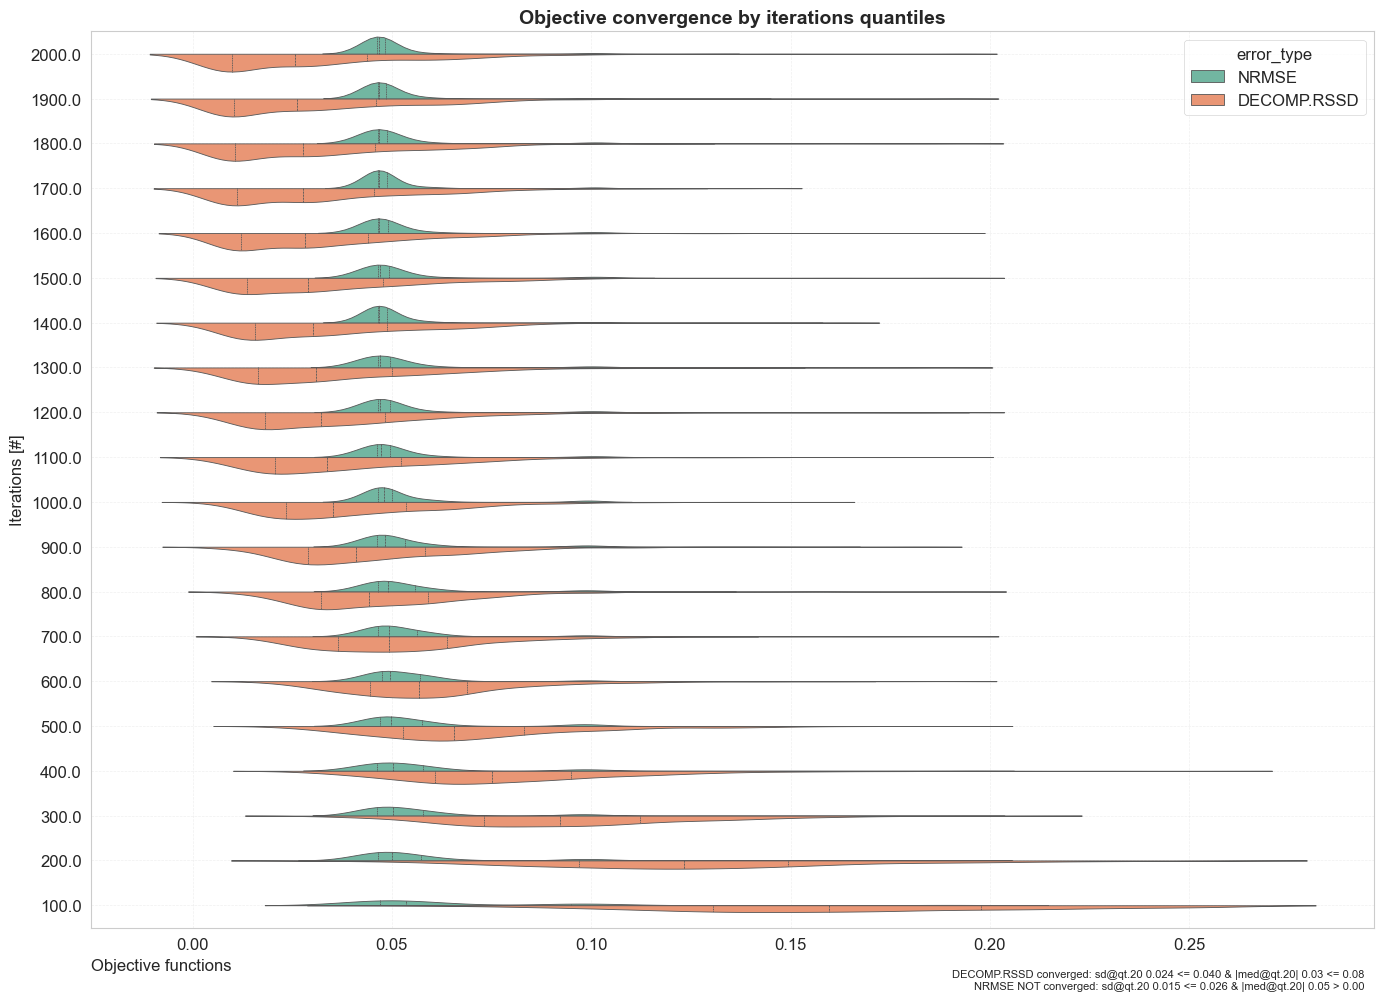

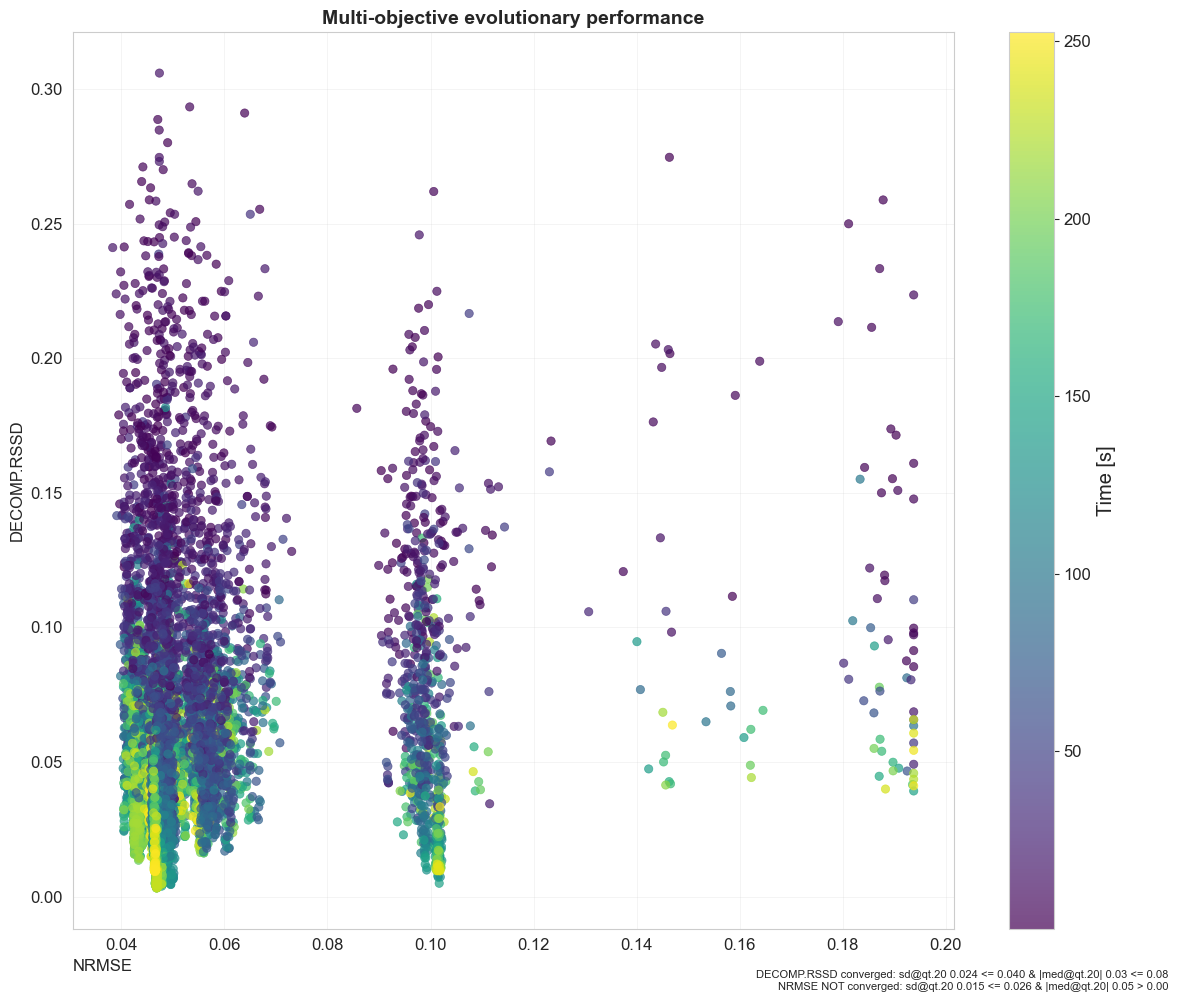

In [21]:
from robyn.modeling.entities.enums import Models, NevergradAlgorithm
from robyn.modeling.entities.modelrun_trials_config import TrialsConfig

trials_config = TrialsConfig(iterations=2000, trials=5)

robyn.train_models(
    trials_config=trials_config,
    ts_validation=True,
    add_penalty_factor=False,
    rssd_zero_penalty=True,
    cores=8,
    nevergrad_algo=NevergradAlgorithm.TWO_POINTS_DE,
    model_name=Models.RIDGE,
)

## Evaluate Models

After training, we cluster similar models to identify stable solutions. This helps find consistent patterns in:
- Model performance metrics
- Channel contribution patterns
- Hyperparameter choices

The clustering process helps select reliable models from our training results.

INFO: Evaluating models
2025-02-07 19:50:24,486 - robyn.robyn - INFO - Evaluating models
2025-02-07 19:50:24 [INFO] Starting Pareto optimization
2025-02-07 19:50:24,489 - robyn.modeling.pareto.data_aggregator - INFO - Starting model data aggregation
2025-02-07 19:50:24 [INFO] Computing Pareto fronts
2025-02-07 19:50:25 [INFO] Pareto front computation completed
2025-02-07 19:50:25 [INFO] Preparing Pareto data
2025-02-07 19:50:26 [INFO] Number of Pareto-optimal solutions found: 8214
2025-02-07 19:50:26 [INFO] Selected 4 Pareto-fronts containing 135 candidates
2025-02-07 19:50:26 [INFO] Selected Pareto fronts: 5
2025-02-07 19:50:26 [INFO] Filtering data for selected Pareto fronts...
2025-02-07 19:50:26 [INFO] Pareto data preparation completed
2025-02-07 19:50:26,115 - robyn.modeling.pareto.response_curve - INFO - Calculating response curves for 675 models' media variables...
Processing rows: 100%|██████████| 675/675 [00:14<00:00, 45.74it/s]
2025-02-07 19:50:41,452 - robyn.modeling.pareto.

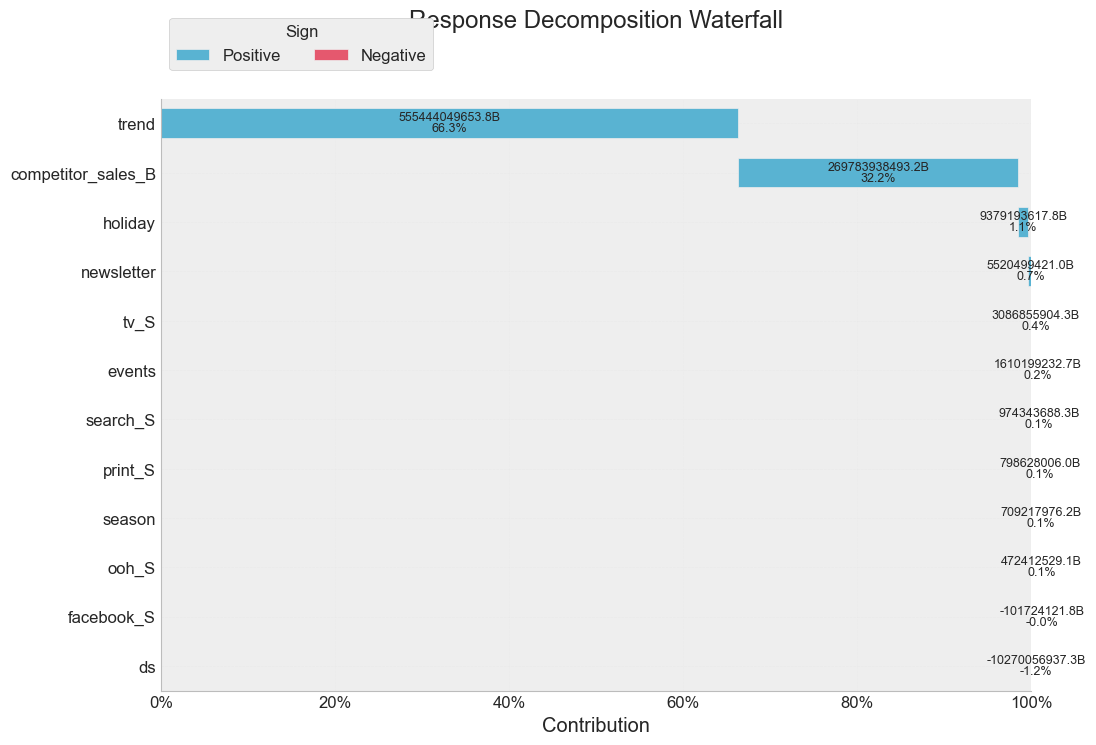

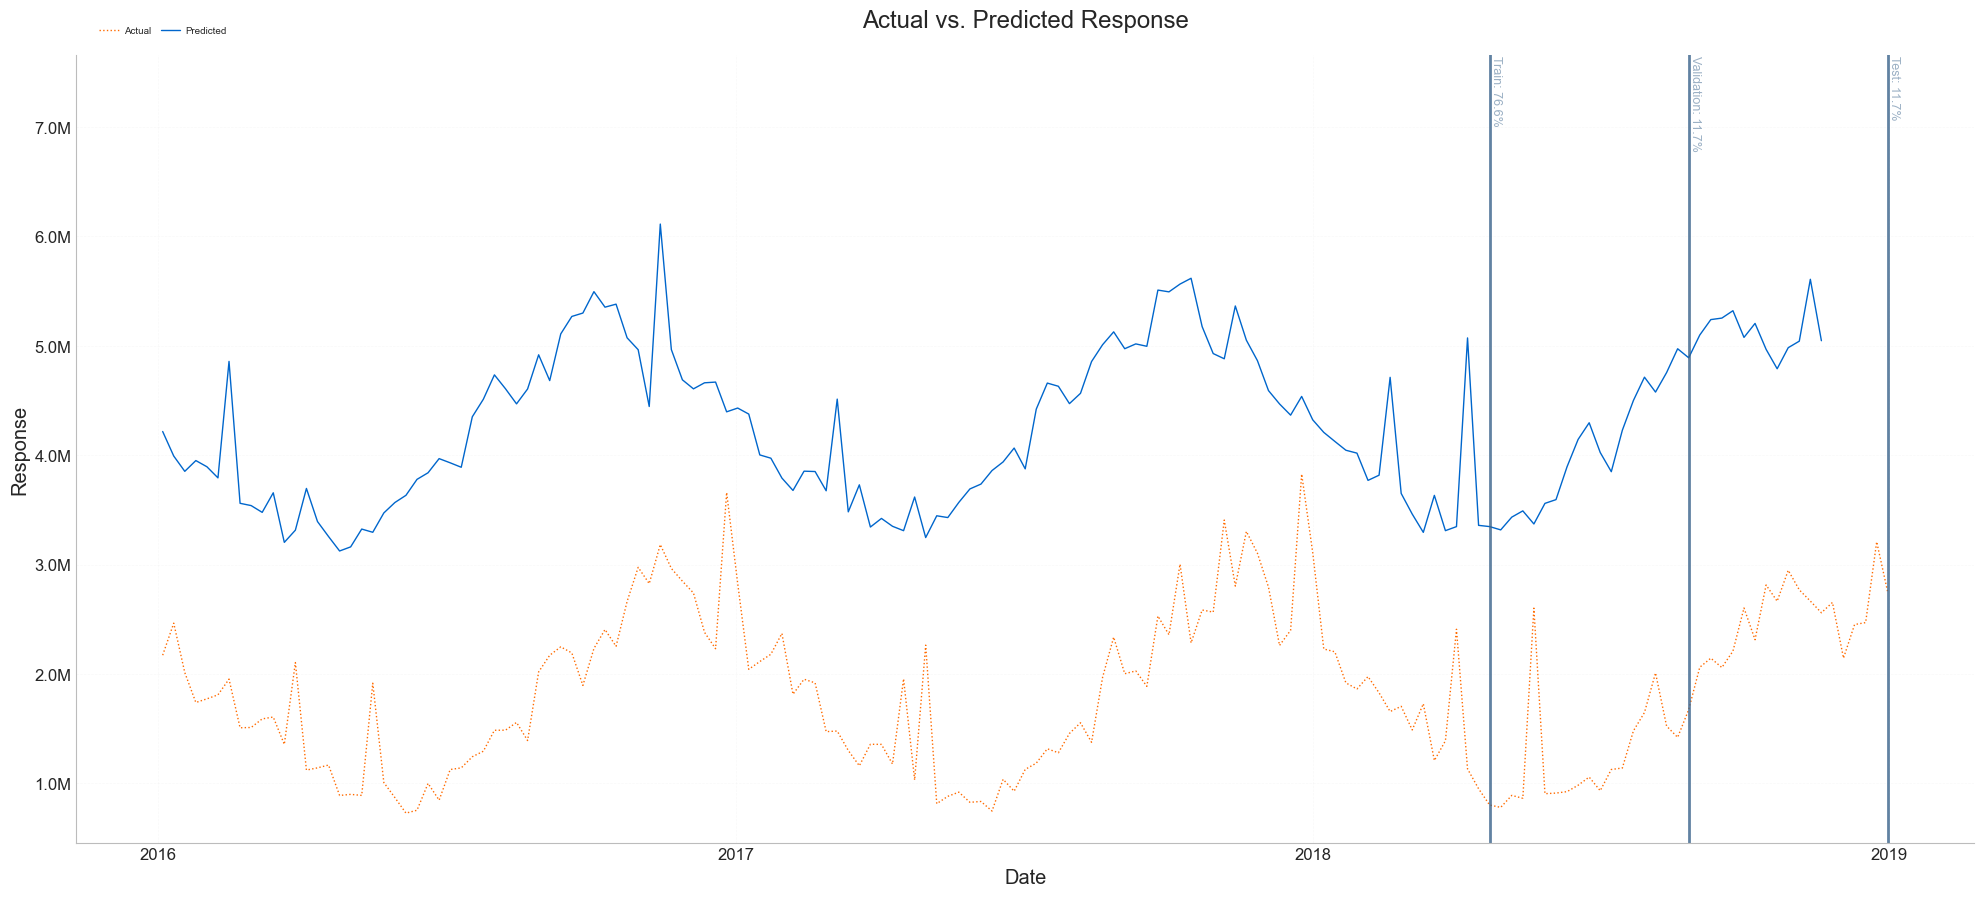

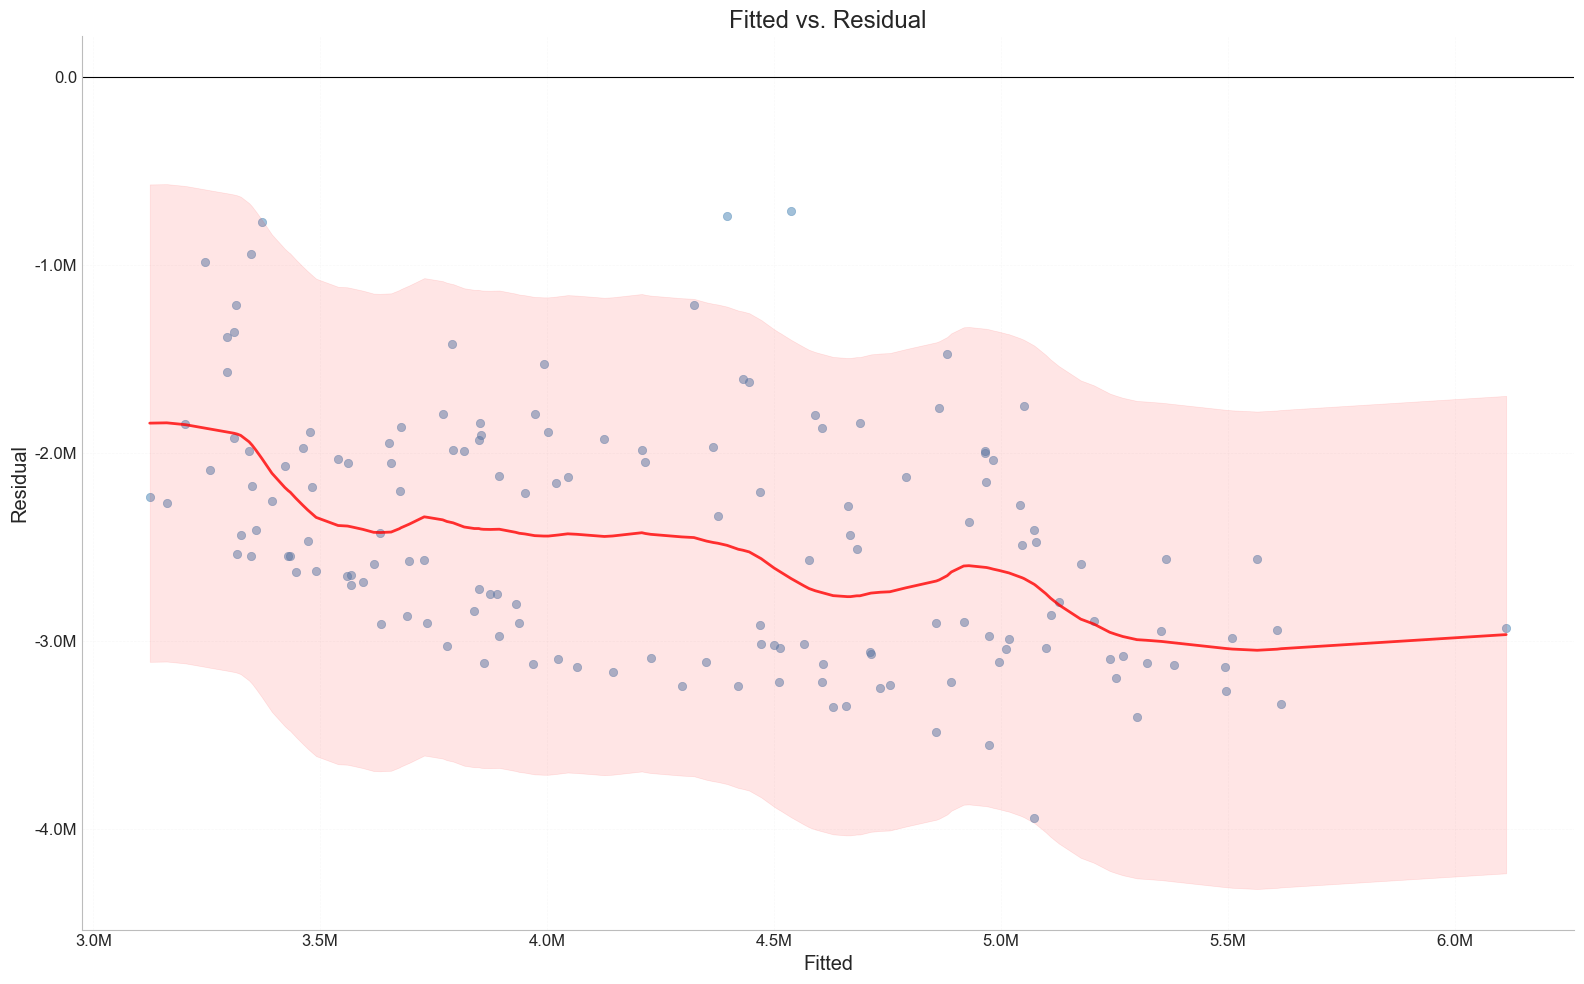

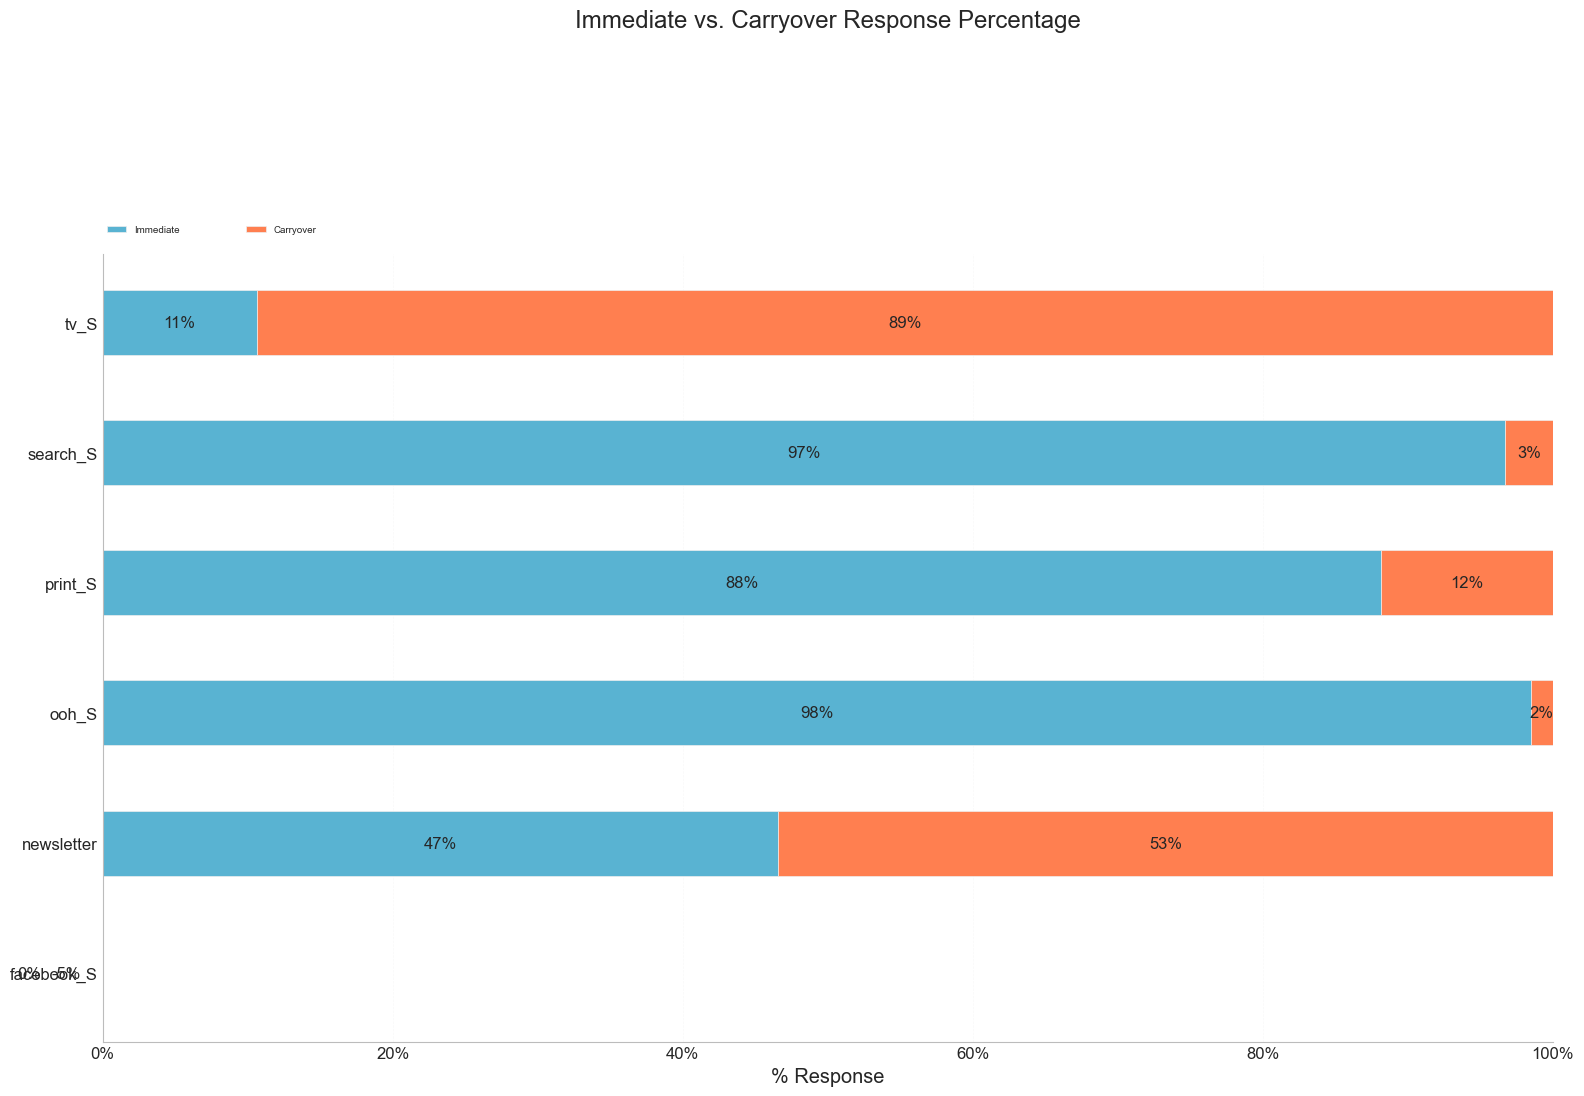

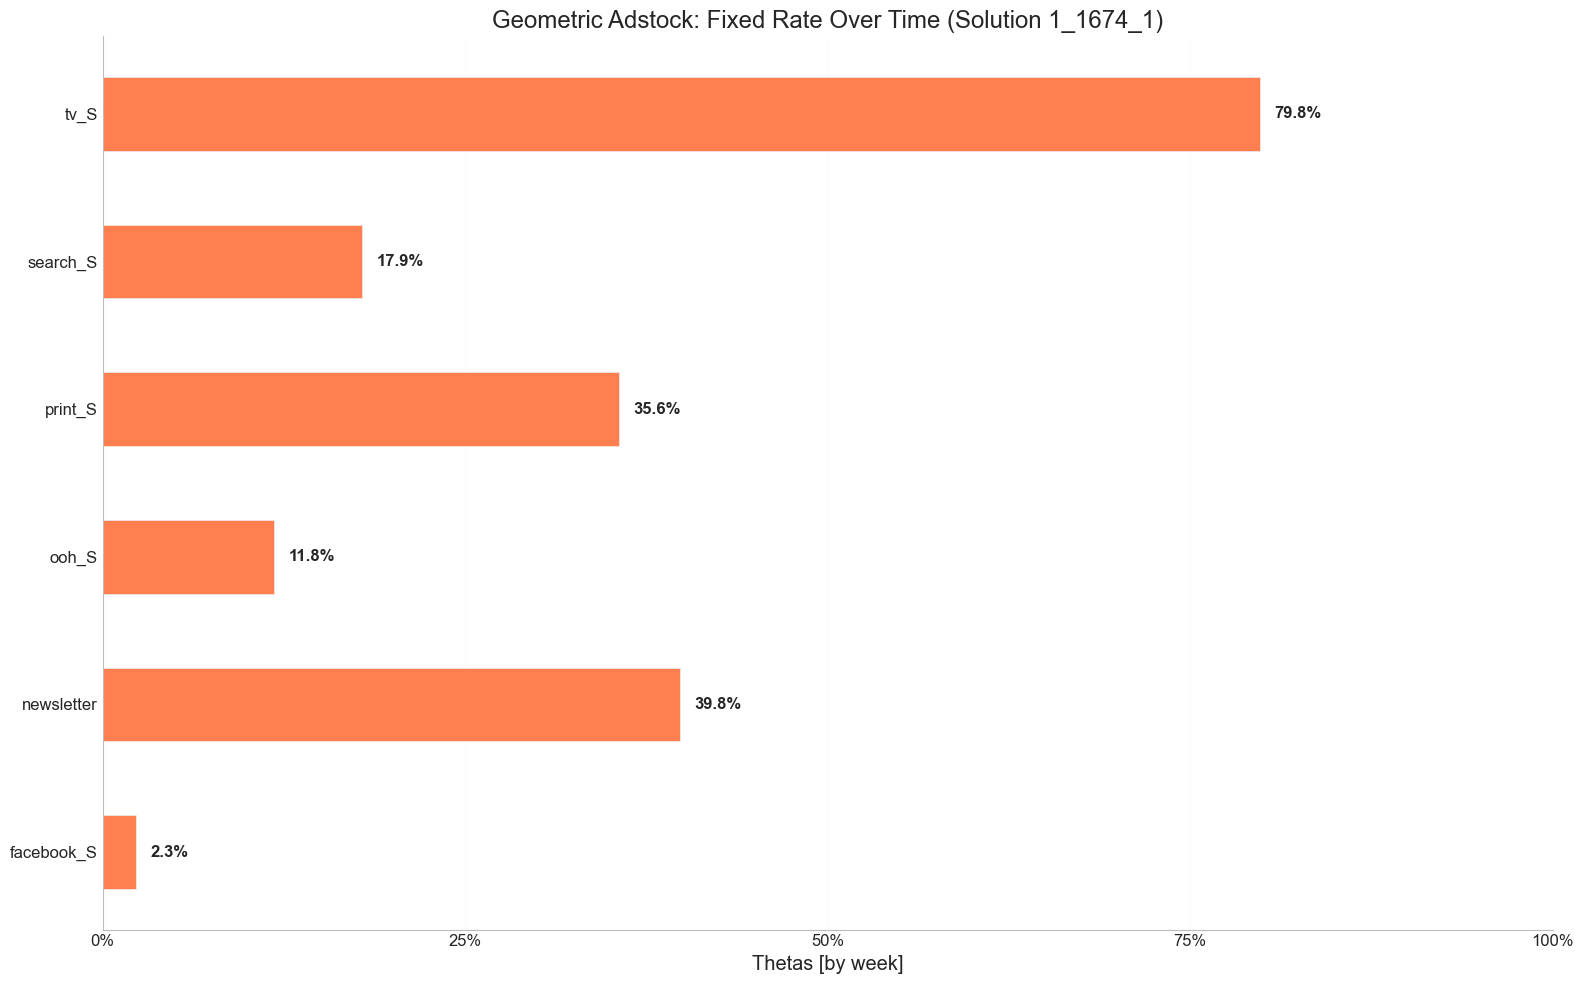

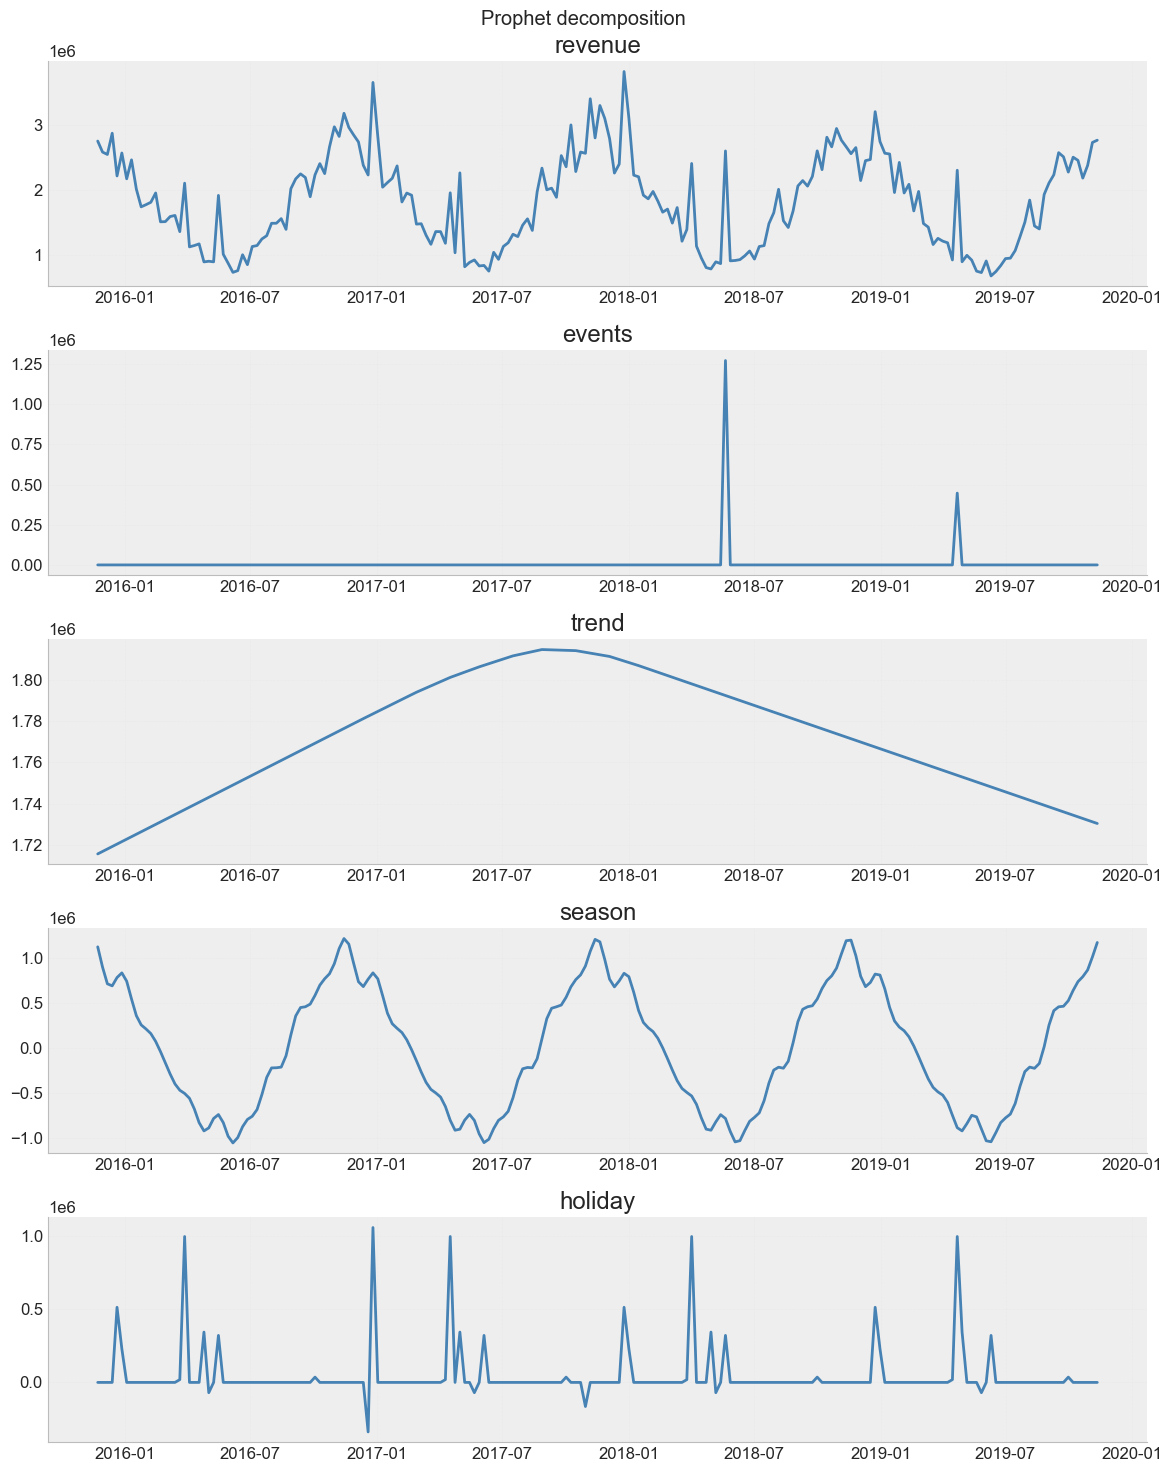

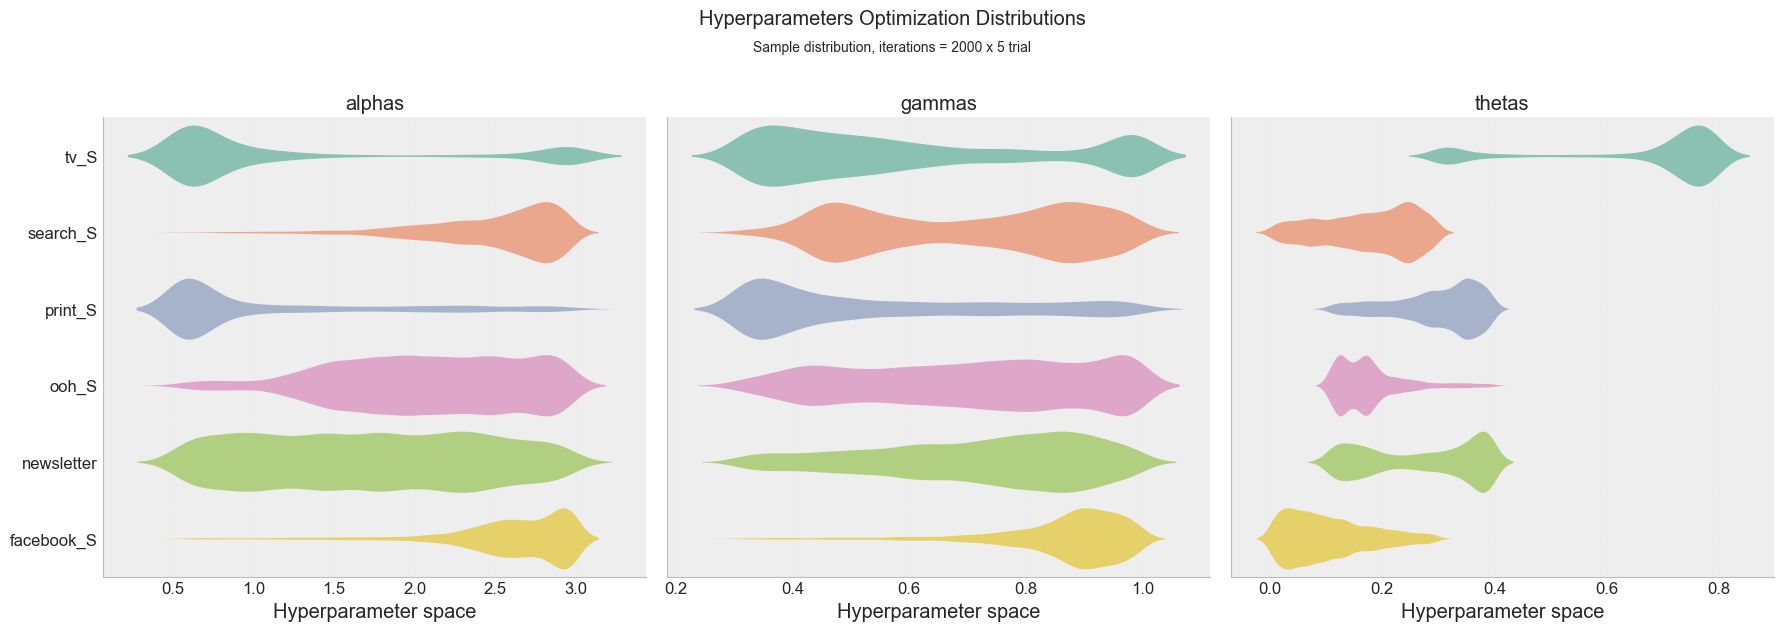

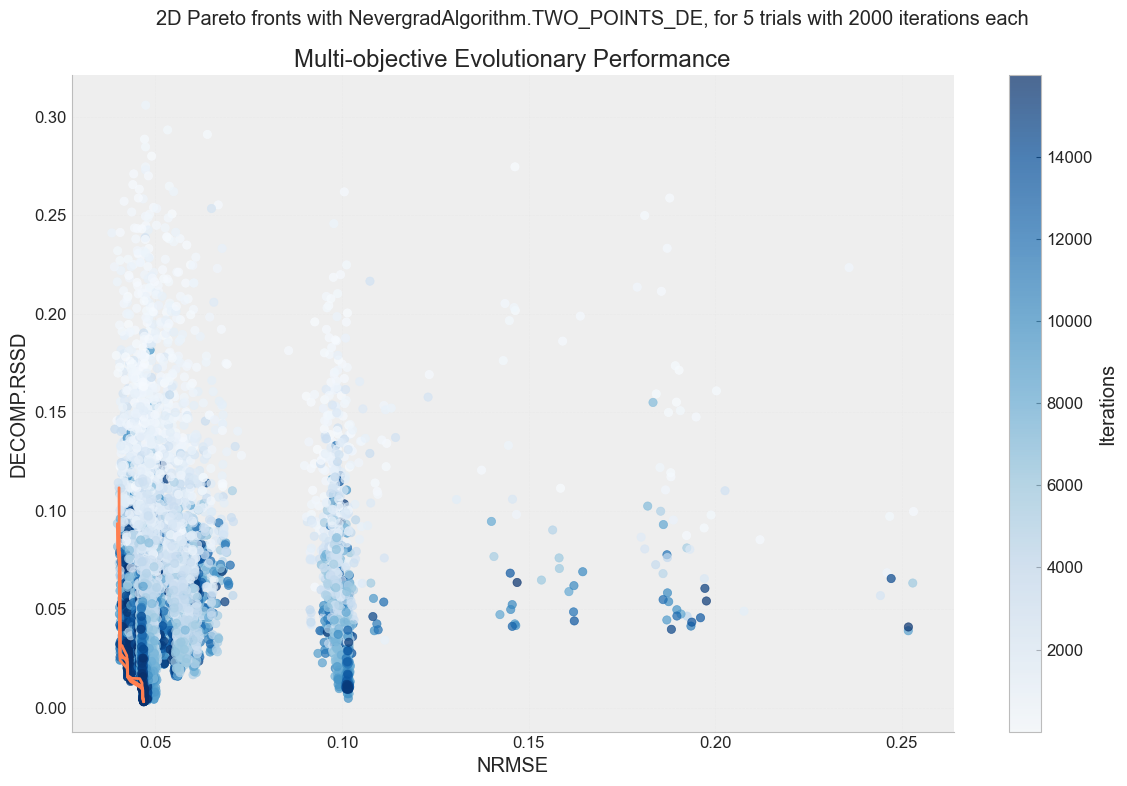

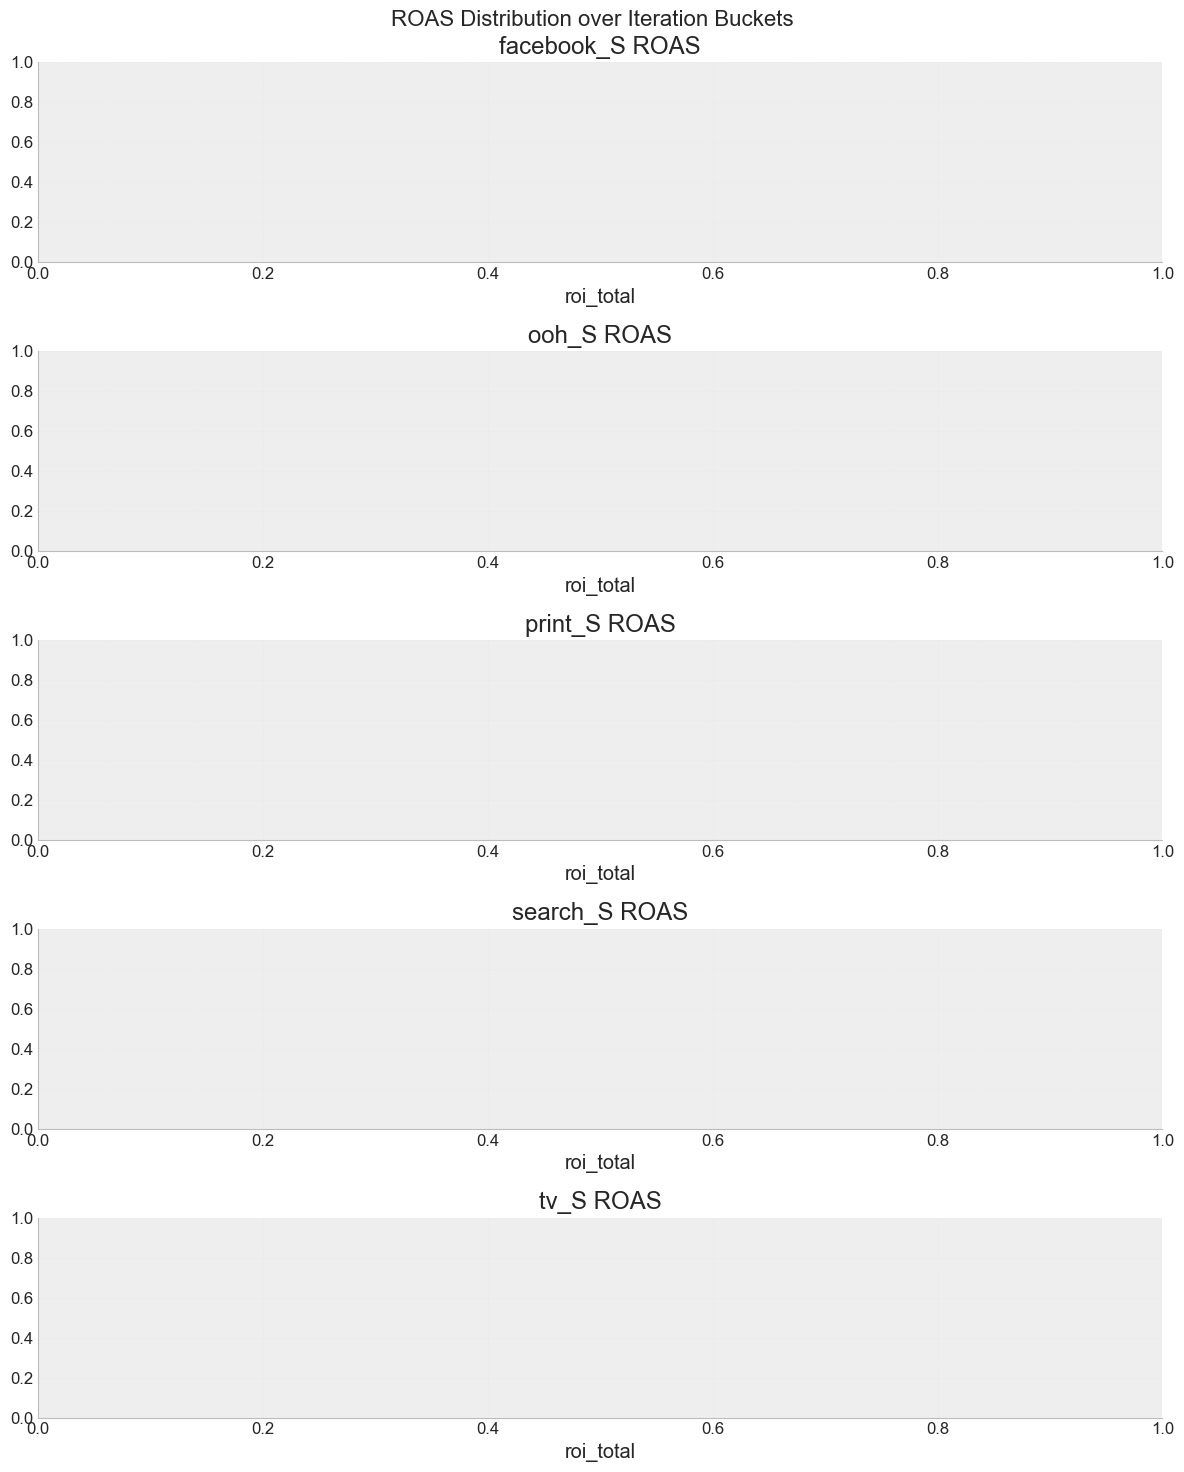

2025-02-07 19:51:46,271 - robyn.visualization.cluster_visualizer - WARNING - create_correlations_heatmap method is not implemented.


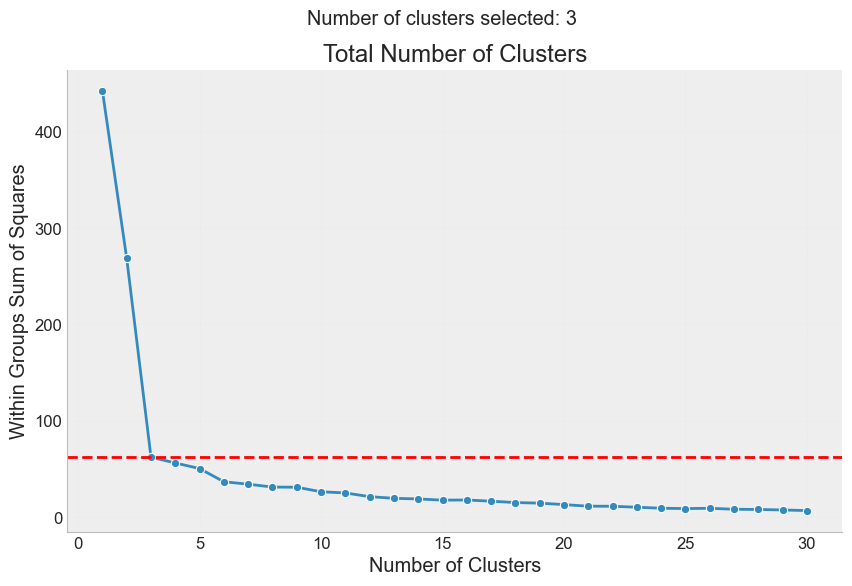

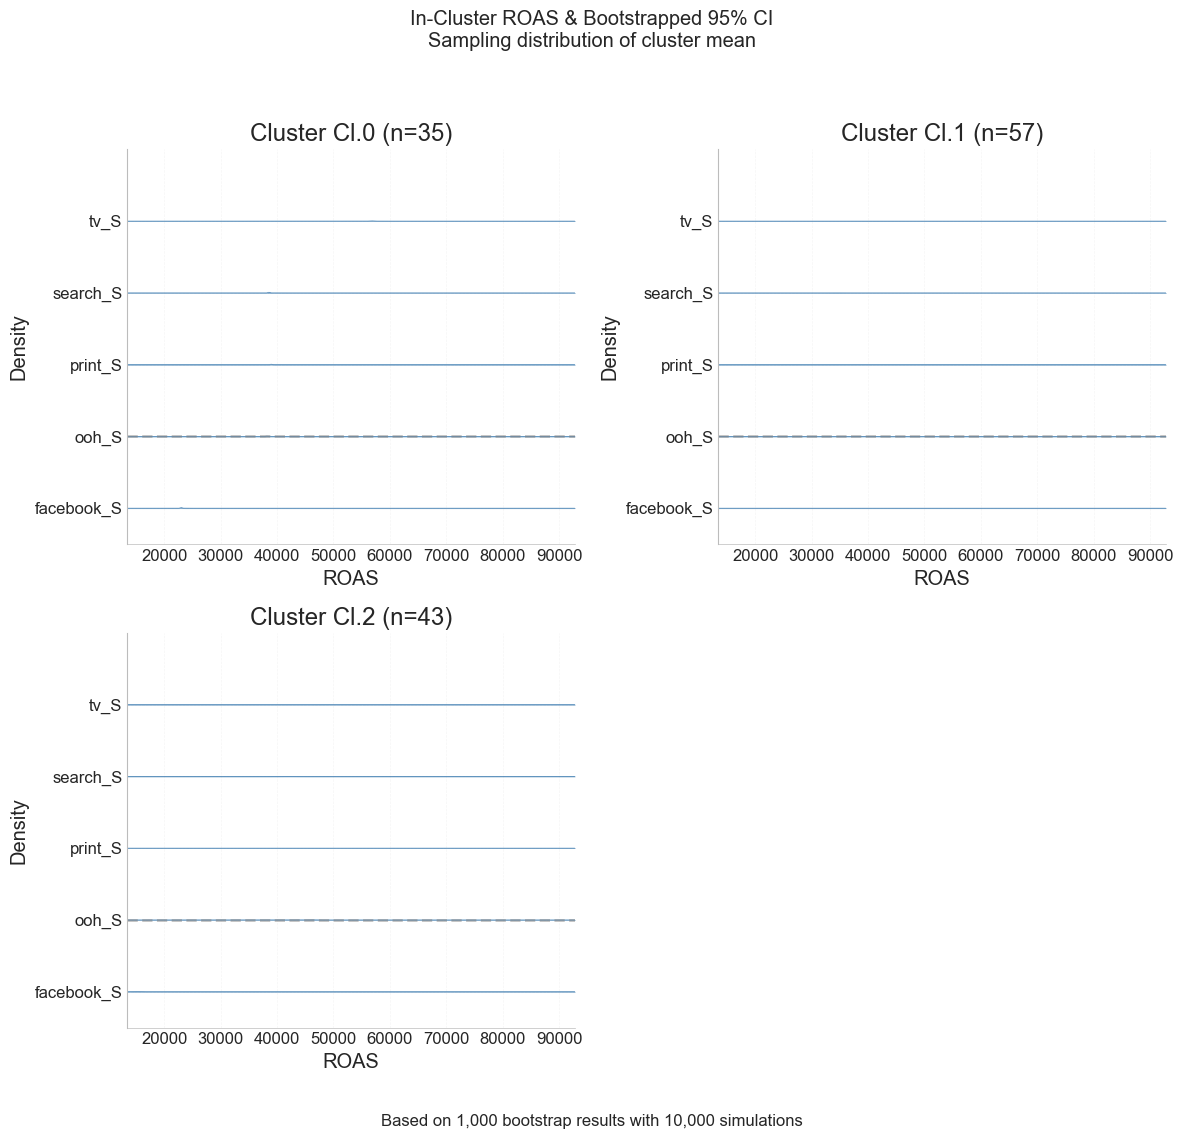

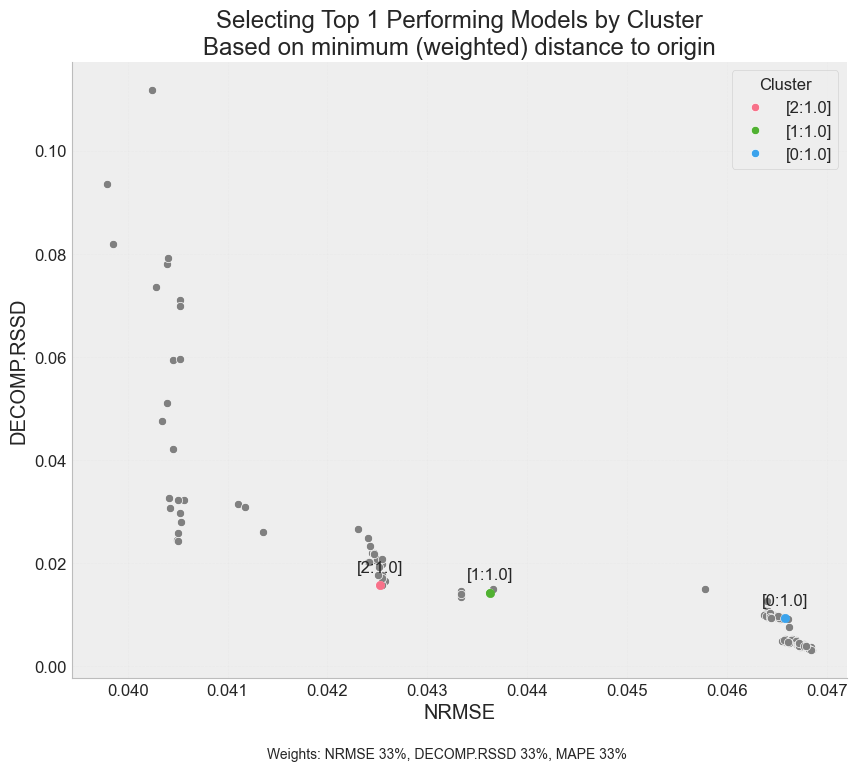

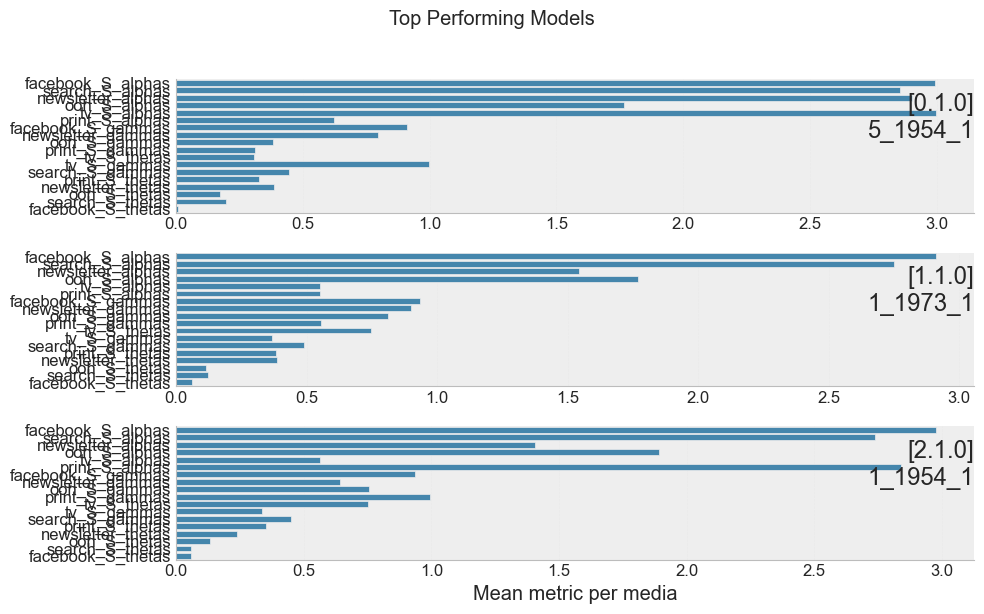

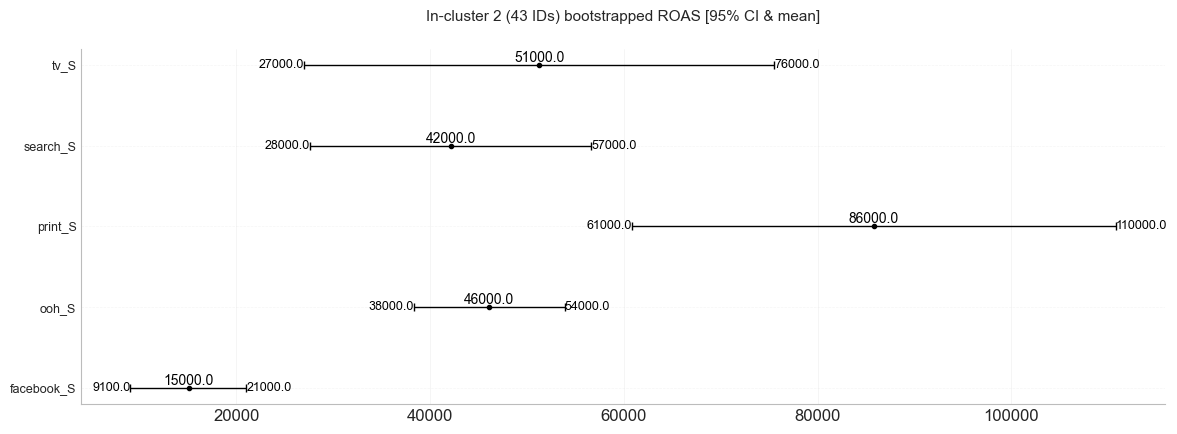

INFO: Model evaluation complete
2025-02-07 19:51:47,025 - robyn.robyn - INFO - Model evaluation complete


In [22]:
from robyn.modeling.clustering.clustering_config import ClusterBy, ClusteringConfig

configs = ClusteringConfig(
    dep_var_type=DependentVarType(mmm_data.mmmdata_spec.dep_var_type),
    cluster_by=ClusterBy.HYPERPARAMETERS,
    max_clusters=10,
    min_clusters=3,
    weights=[1.0, 1.0, 1.0],
)

robyn.evaluate_models(cluster_config=configs)

## Generate One-Pager Report

The one-pager visualizes key model results and diagnostics through 8 plots:
- Channel performance: Spend vs Effect comparisons and ROI metrics
- Model fit: Decomposition, actual vs predicted, and residual analysis  
- Response patterns: Carryover effects, adstock rates, and channel response curves
- Model stability: Bootstrapped performance metrics

[<Figure size 3000x3400 with 8 Axes>,
 <Figure size 3000x3400 with 8 Axes>,
 <Figure size 3000x3400 with 8 Axes>]

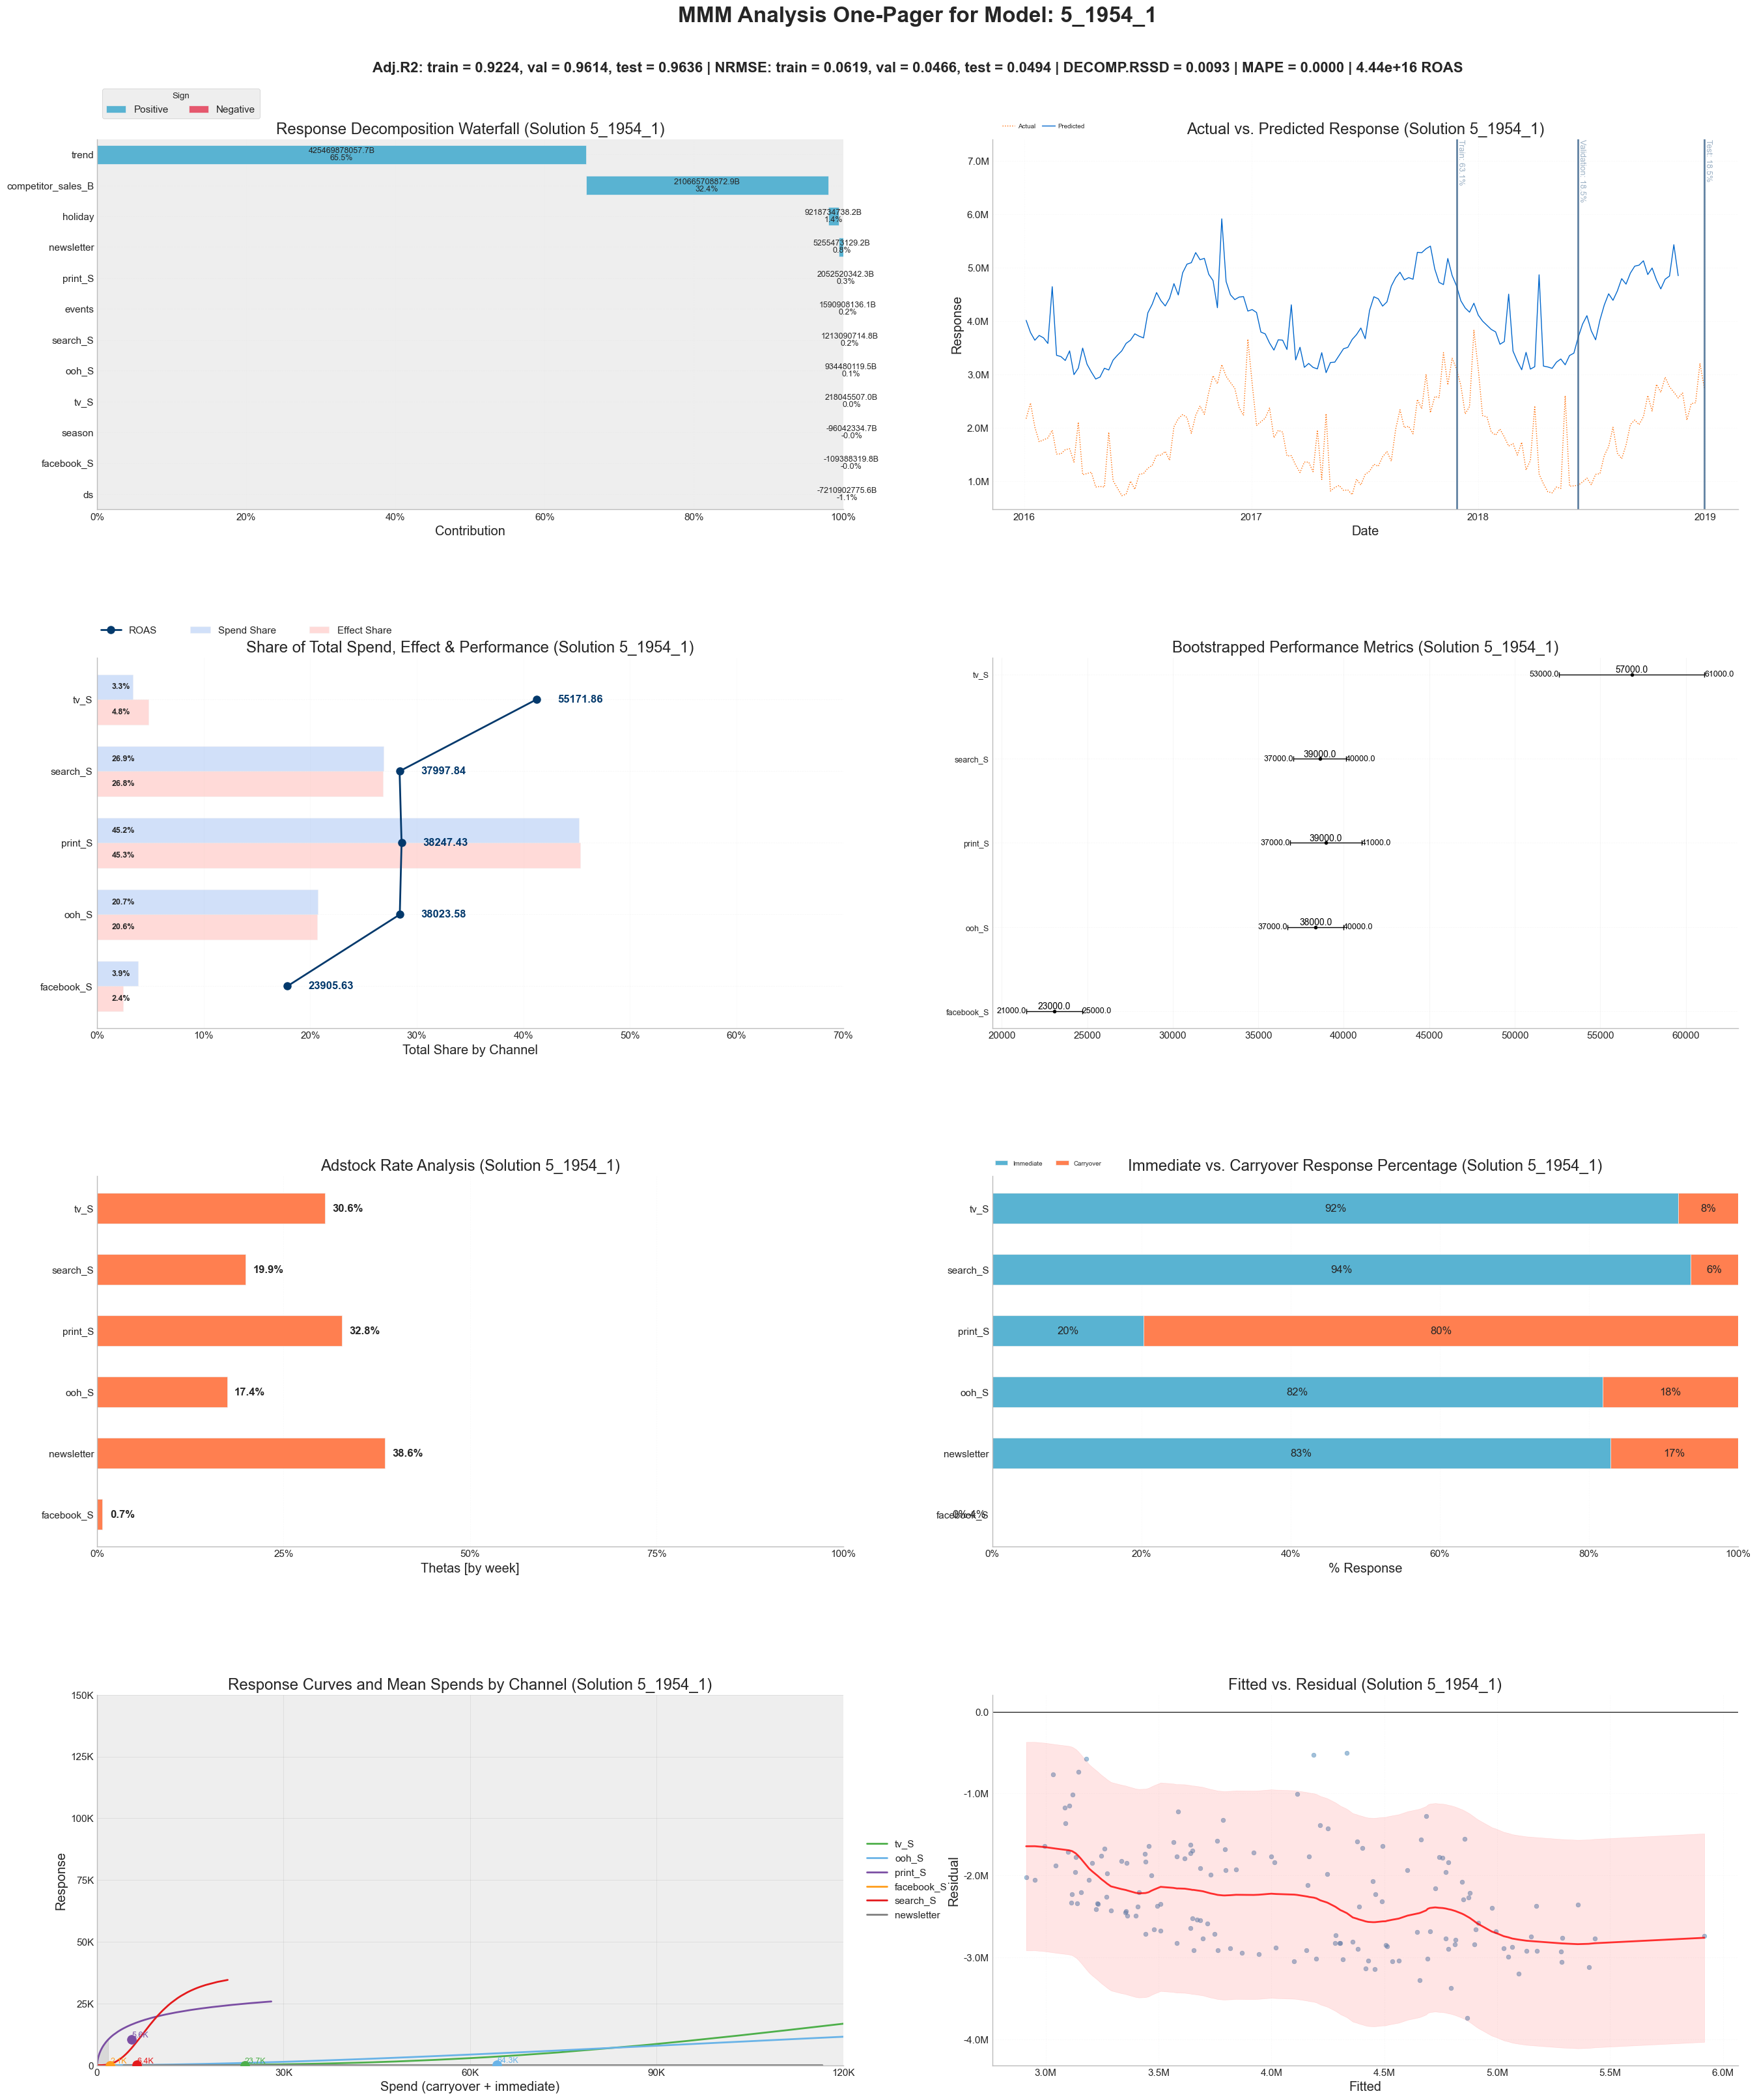

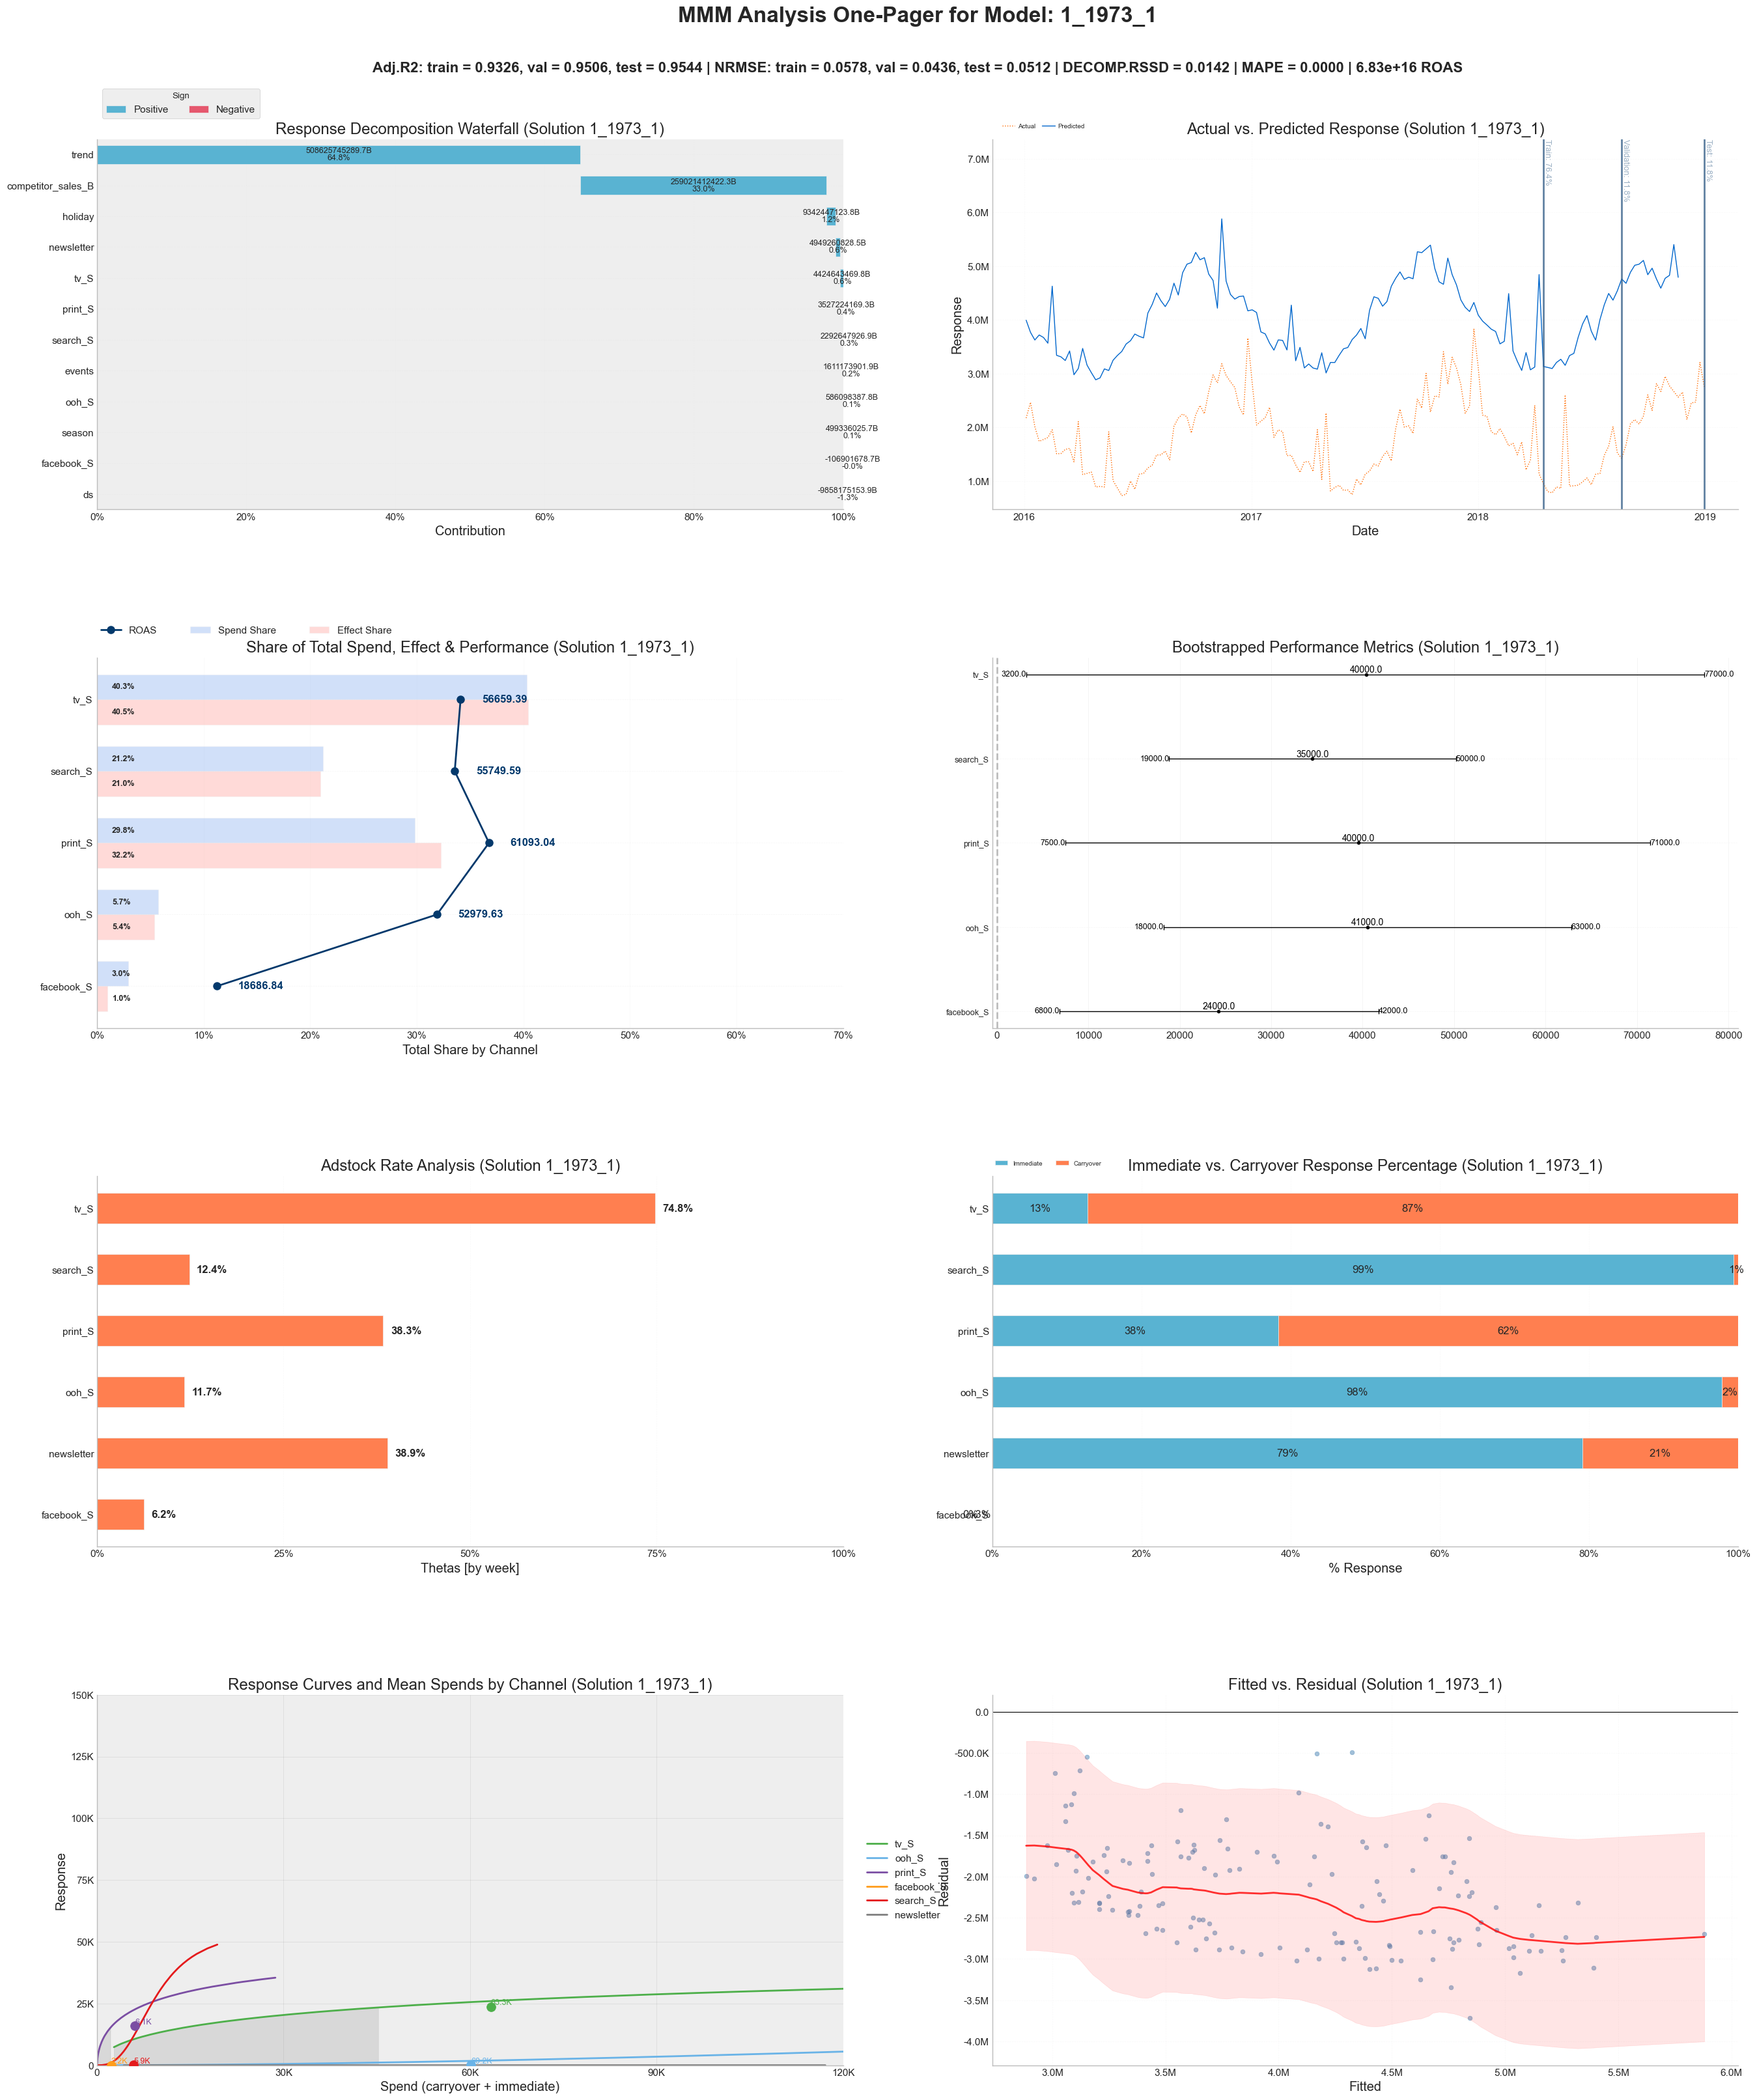

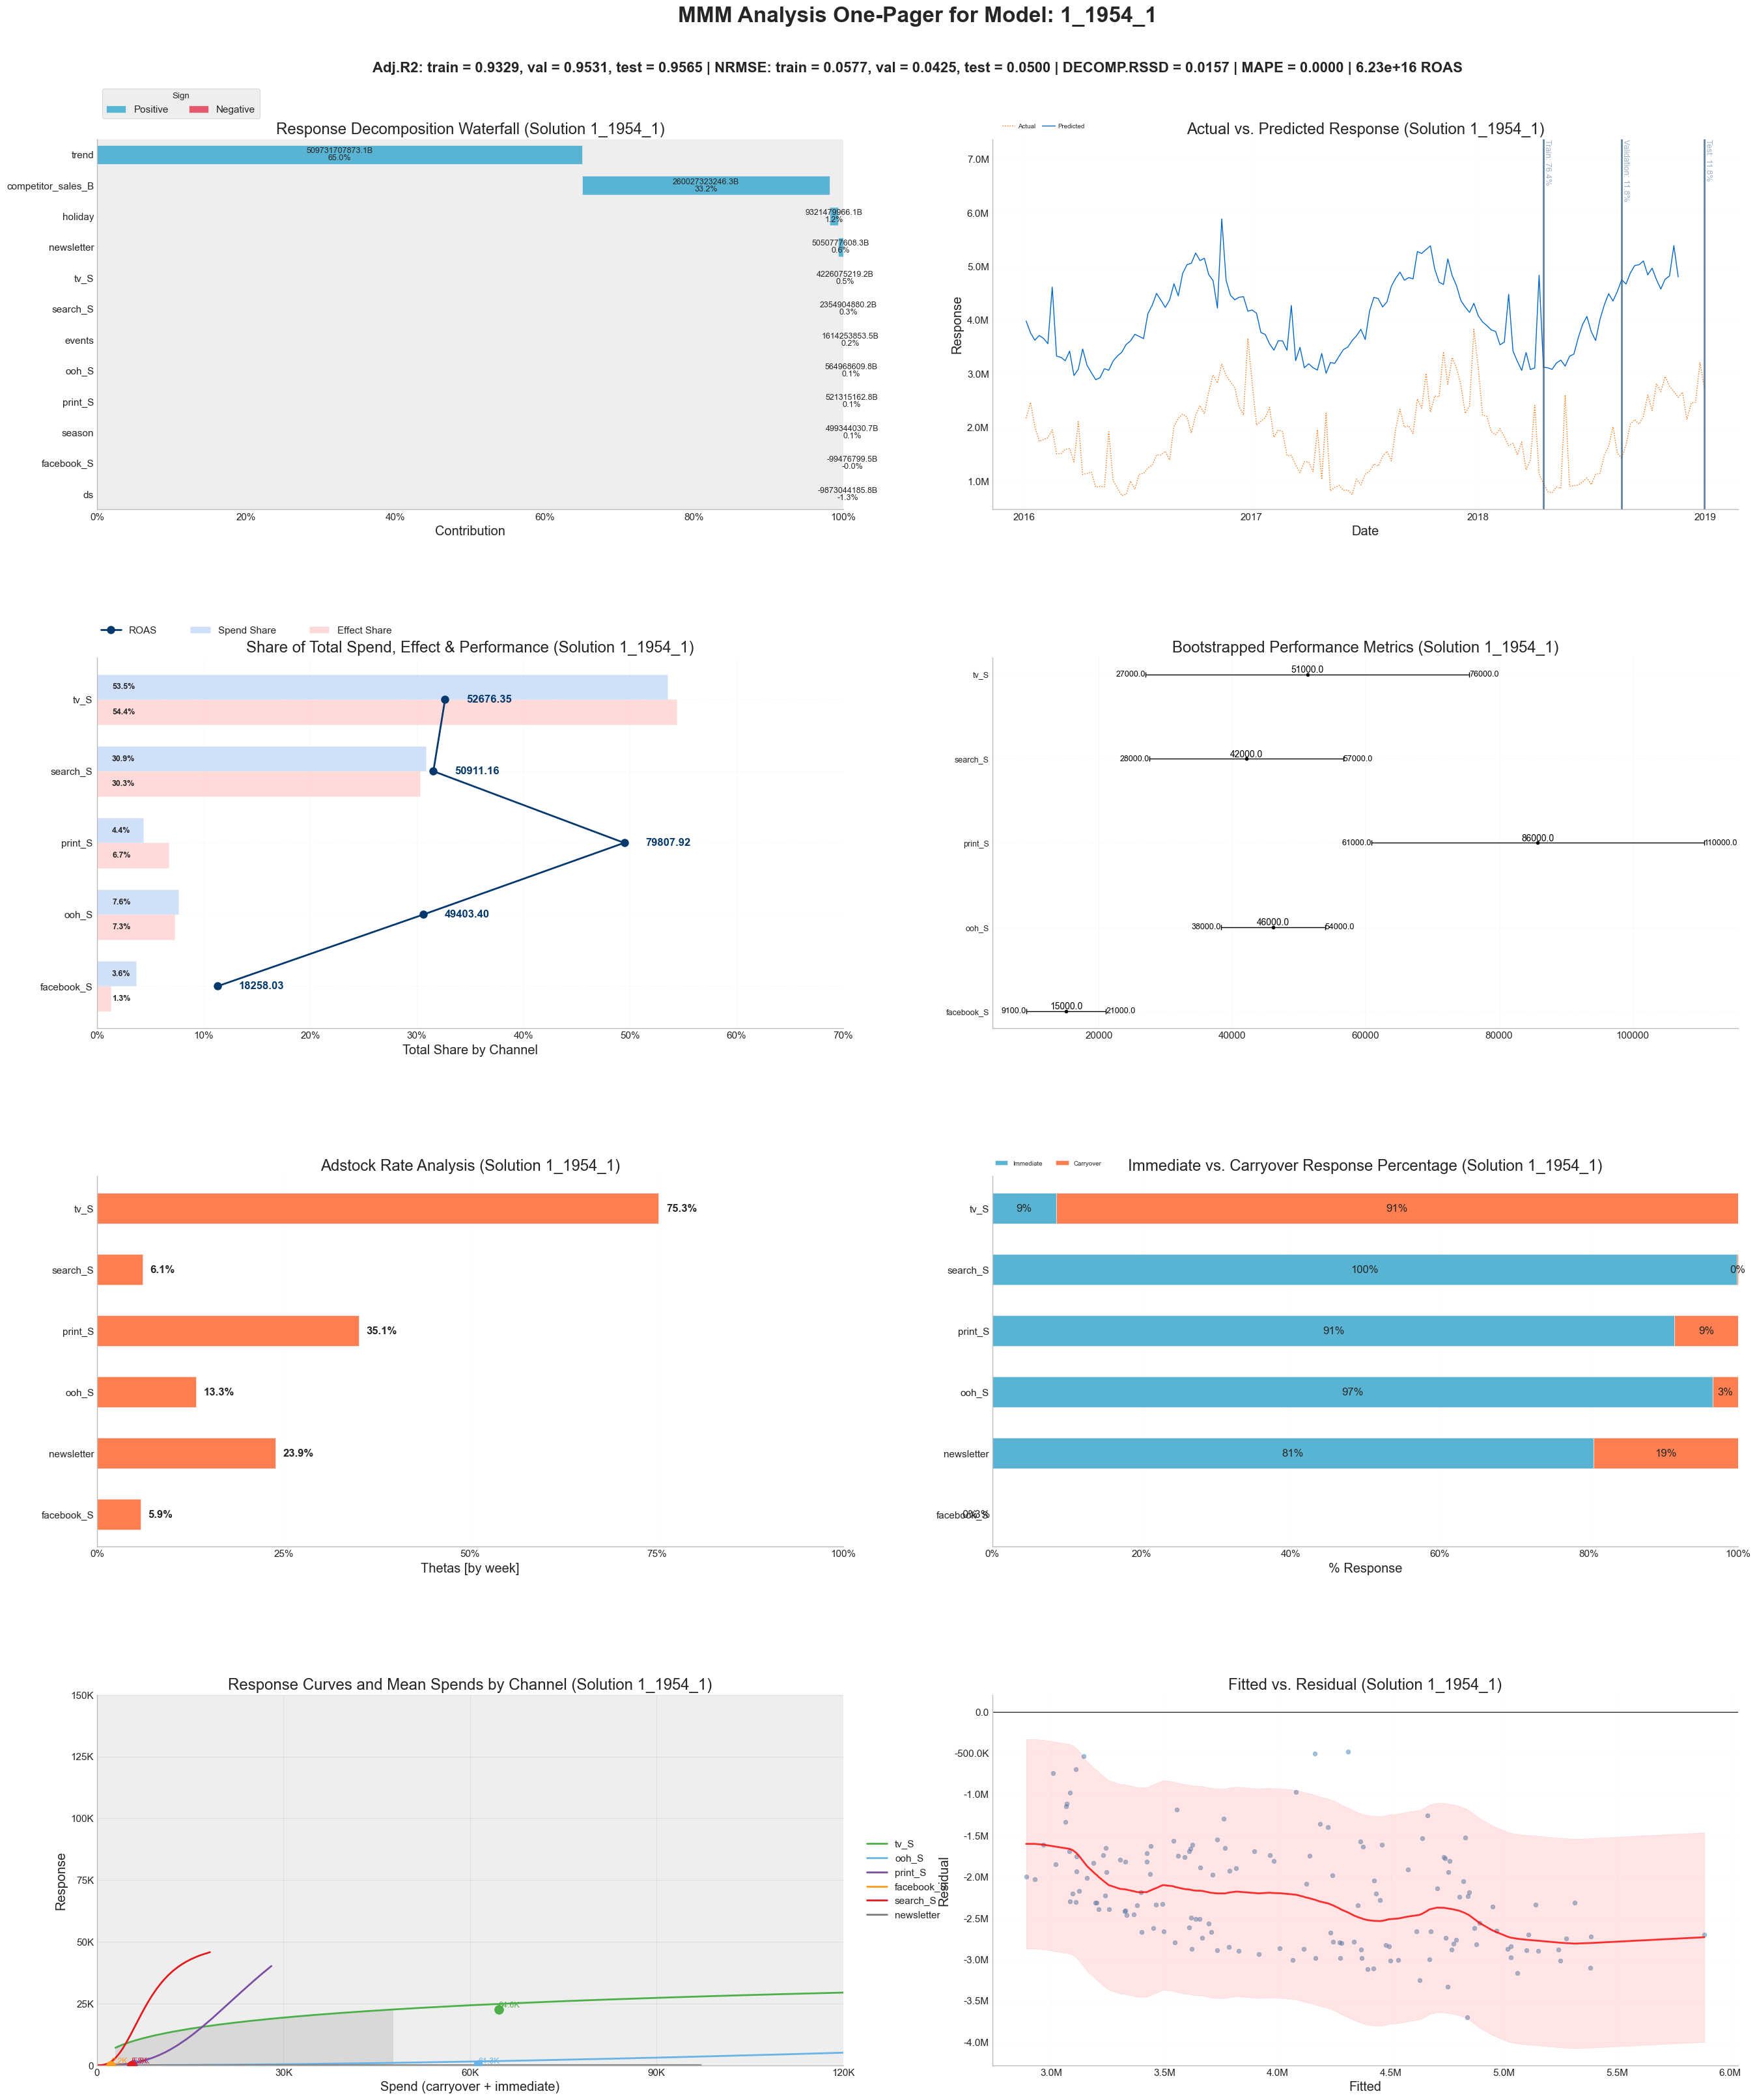

In [23]:
robyn.generate_one_pager()

In [ ]:
robyn.generate_one_pager(solution_id="1_1994_1")

## Budget Allocation Optimization

Robyn provides different scenarios for budget allocation optimization. Let's explore the "max_response" scenario:

### Scenario: Maximum Response
This scenario answers the question: "What's the maximum return given certain spend constraints?"

Key parameters:
- `total_budget`: When set to None, uses the total spend in the selected date range
- `channel_constr_low`: Minimum spend multiplier (e.g., 0.7 means channel spend can't go below 70% of current)
- `channel_constr_up`: Maximum spend multiplier per channel (e.g., 1.5 means channel spend can't exceed 150% of current)
- `channel_constr_multiplier`: Extends bounds for wider optimization insights
- `date_range`: Period for optimization ("all", "last_X", or specific date range)

Note: Other scenarios include:
- "target_efficiency": Optimize spend to hit specific ROAS or CPA targets
- "min_spend": Find minimum spend required to hit response targets
- "max_response_expected": Maximize expected response within confidence intervals

For this example, we'll demonstrate the "max_response" scenario:

INFO: Optimizing budget allocation
2025-02-07 19:56:03,820 - robyn.robyn - INFO - Optimizing budget allocation
INFO: Selected model for budget optimization: 1_1674_1
2025-02-07 19:56:03,823 - robyn.robyn - INFO - Selected model for budget optimization: 1_1674_1
2025-02-07 19:56:04,183 - robyn.visualization.allocator_visualizer - INFO - Initializing AllocatorPlotter
2025-02-07 19:56:04,188 - robyn.visualization.allocator_visualizer - INFO - Creating all plots for model 1_1674_1
2025-02-07 19:56:04,188 - robyn.visualization.allocator_visualizer - INFO - Creating budget comparison plot
2025-02-07 19:56:04,232 - robyn.visualization.allocator_visualizer - INFO - Creating allocation matrix plot


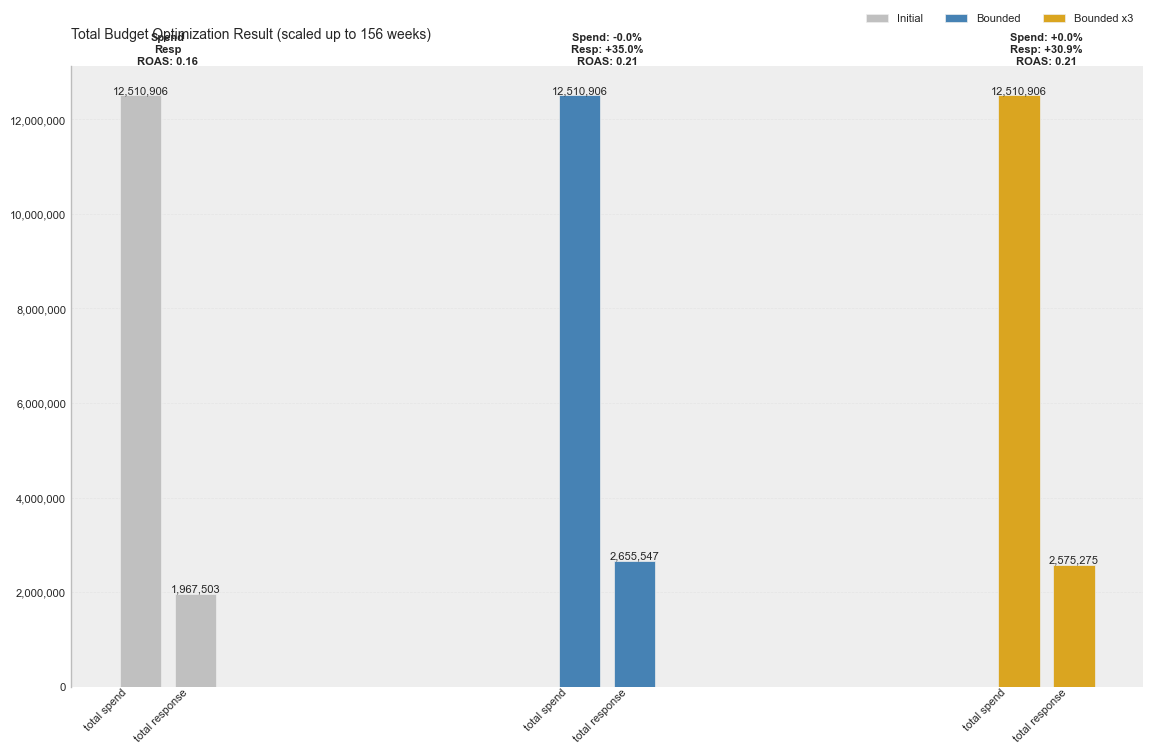

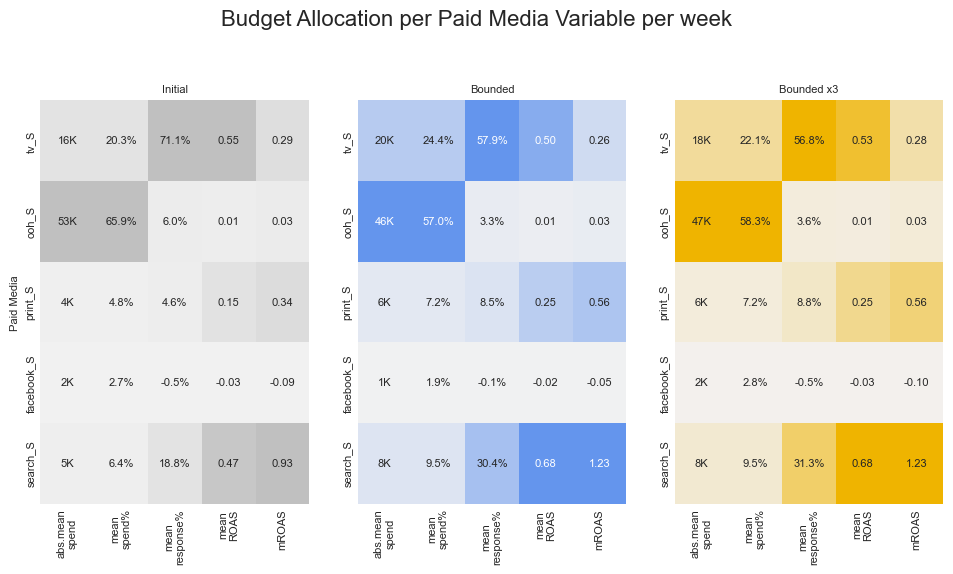

2025-02-07 19:56:04,738 - robyn.visualization.base_visualizer - INFO - Saving multiple plots to: C:\Users\barre\Documents\Python Projects\Robyn\python\src\robyn\tutorials\output
2025-02-07 19:56:05,016 - robyn.visualization.base_visualizer - INFO - Plot budget_opt saved successfully
2025-02-07 19:56:05,365 - robyn.visualization.base_visualizer - INFO - Plot allocation saved successfully
INFO: Budget optimization complete
2025-02-07 19:56:05,366 - robyn.robyn - INFO - Budget optimization complete


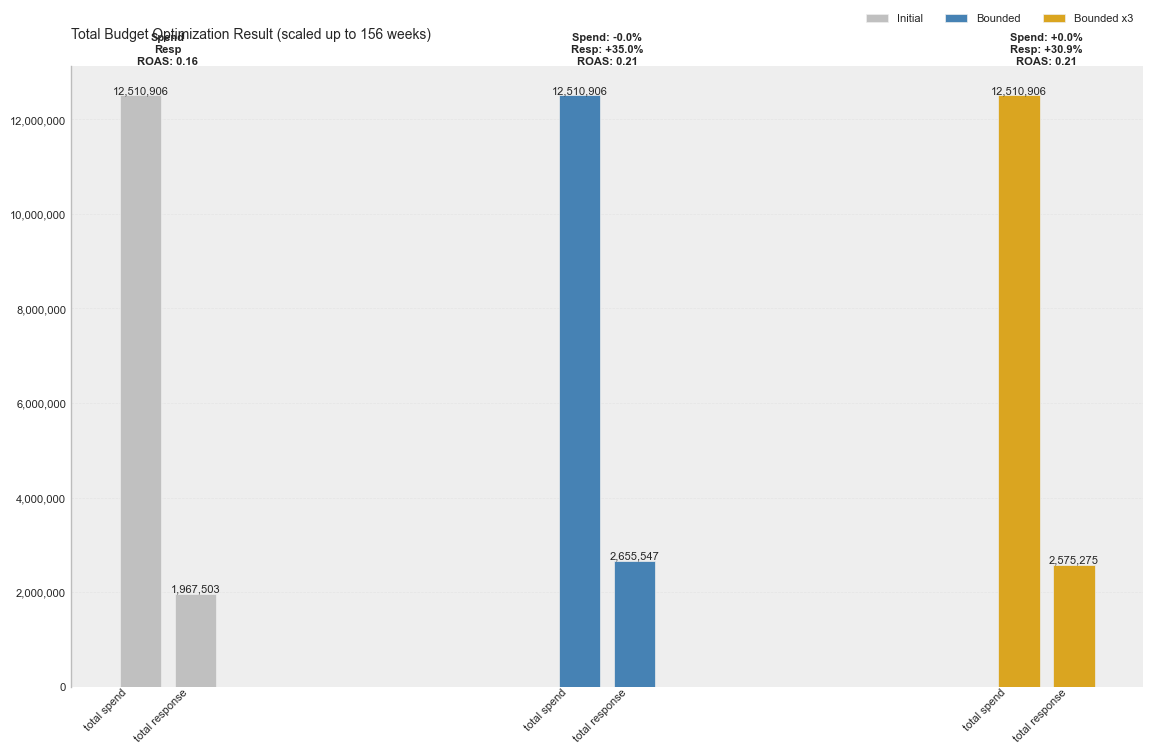

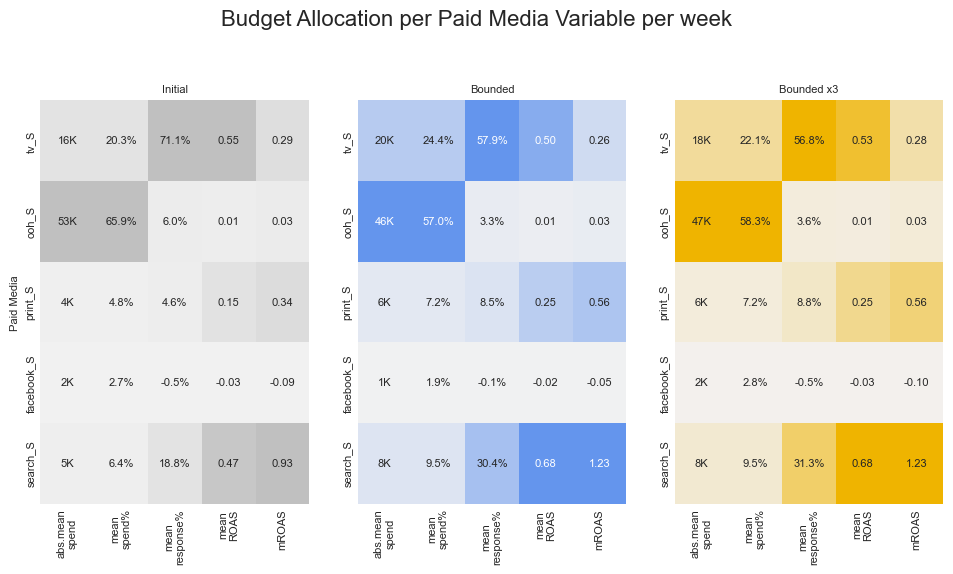

In [25]:
from robyn.allocator.entities.allocation_params import AllocatorParams
from robyn.allocator.constants import (
    SCENARIO_MAX_RESPONSE,
    CONSTRAINT_MODE_EQ,
)

allocator_params = AllocatorParams(
    scenario=SCENARIO_MAX_RESPONSE,
    total_budget=None,  # Uses total spend in date_range when None
    date_range="all",
    channel_constr_low=[0.7],  # Minimum spend multiplier
    channel_constr_up=[1.2, 1.5, 1.5, 1.5, 1.5],  # Maximum spend multiplier
    channel_constr_multiplier=3.0,
    optim_algo="SLSQP_AUGLAG",
    maxeval=100000,
    constr_mode=CONSTRAINT_MODE_EQ,
    plots=True,
)

allocation_result = robyn.optimize_budget(
    allocator_params=allocator_params,
    select_model=None,
)